In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import unicodedata
from pathlib import Path
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from matplotlib.gridspec import GridSpec
import pickle
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import os



In [2]:
# LOAD CIRCUIT GEOMETRY UNIQUE

circuit_geometry = pd.read_csv('csv_output/Circuit_geometry_unique.csv')

print("Circuit Geometry Dataset")
print(f"Shape: {circuit_geometry.shape}")
print(f"Columns: {circuit_geometry.columns.tolist()}")
print(f"Unique circuits: {circuit_geometry['circuitRef'].nunique()}")


# LOAD COMBINED LAP TIMING CLEAN

lap_timing = pd.read_excel('csv_output/Combined_Lap_Timing_Final.xlsx')

print(f"\nCombined Lap Timing Final Dataset")

print(f"Shape: {lap_timing.shape}")
print(f"Columns: {lap_timing.columns.tolist()}")
print(f"Total Rows: {len(lap_timing)}")



Circuit Geometry Dataset
Shape: (24, 28)
Columns: ['circuitRef', 'year', 'round', 'name', 'type', 'num_drs_zones', 'length_km', 'num_turns', 'slow_corners', 'medium_corners', 'fast_corners', 'flat_corners', 'slow_cluster_max', 'straight_distance_m', 'straight_ratio', 'straight_len_max_m', 'n_major_straights', 'heavy_braking_zones', 'heavy_braking_mean_dv_kmh', 'hb_spacing_std_m', 'hb_at_end_of_max', 'corner_density_tpkm', 'avg_corner_angle', 'total_corner_angle', 'avg_corner_distance', 'drs_zones_detected', 'drs_total_len_m', 'drs_on_max']
Unique circuits: 24

Combined Lap Timing Final Dataset
Shape: (73592, 26)
Columns: ['year', 'round', 'name', 'Grand_Prix', 'Name', 'RacingNumber', 'Team', 'lap_number', 'LapTime', 'IntervalToPositionAhead', 'Position', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed', 'Rainfall', 'any_violation', 'lap_clean', 'Stint', 'Compound', 'TyreAgeAtStart', 'LapInStint', 'PitStop', 'Pit_Out']
Total Rows: 73592


<h3><center> From interval to position ahead we derive traffic feutre(dirty air/clean air) </center></h3>

In [3]:

def create_traffic_and_behavior_features(df,drs_thresh=1.1,clean_thresh=3.0,interp_limit=1):
    """
    Traffic & behavior features: gap parsing, traffic regimes,

    Returns
    -------
    DataFrame with columns:
      - is_leadern_drs_range, in_dirty_air, in_clean_air
    """
    df = df.copy()

    print(f"\nCreating traffic features(clean air, dirty air, DRS range)")

    # Sort for temporal operations
    keys = ['year', 'round', 'RacingNumber', 'Stint', 'lap_number']
    df = df.sort_values(keys)

    # Parse IntervalToPositionAhead robustly (no arbitrary values for leaders)

    s = df['IntervalToPositionAhead'].astype(str)

    # Leader flag: Position==1 OR LAPk tokens
    df['is_leader'] = ((df['Position'] == 1) | s.str.upper().str.contains(r'\bLAP\s*\d+\b')).astype(int)

    # Extract FIRST numeric token anywhere in the string; handles "1.23", "+1.23", "1,23", "1.23s", etc.
    num_str = s.str.extract(r'([-+]?\d+(?:[.,]\d*)?)', expand=False)
    num_clean = num_str.str.replace(',', '.', regex=False).str.strip()
    gap_num = pd.to_numeric(num_clean, errors='coerce')

    # Numeric gap only for non-leaders; leaders have no numeric gap
    df['gap_seconds_raw'] = np.where(df['is_leader'].values == 0, gap_num.values, np.nan)
    df['gap_numeric_valid'] = df['gap_seconds_raw'].notna().astype(int)

    # ── 3) Conservative interpolation: only isolated 1-lap holes within (year, round, driver)

    grp = df.groupby(['year', 'round', 'RacingNumber'], group_keys=False)
    df['gap_seconds_interp'] = grp['gap_seconds_raw'].apply(
        lambda x: x.interpolate(limit=interp_limit, limit_direction='both')
    )

    # Adopt interpolation only where original was NaN
    df['gap_seconds'] = df['gap_seconds_raw'].where(df['gap_seconds_raw'].notna(), df['gap_seconds_interp'])
    df['gap_missing'] = (df['gap_seconds'].isna() & (df['is_leader'] == 0)).astype(int)

    # Optional: capped numeric (useful for trees/GBMs; not required for linear+dummies)
    #df['gap_capped'] = df['gap_seconds'].clip(lower=0, upper=6)

    # 4) Traffic regime dummies (mutually exclusive physical regimes)

    df['in_drs_range'] = ((df['is_leader'] == 0) & df['gap_seconds'].notna() & (df['gap_seconds'] <= drs_thresh)).astype(int)
    df['in_dirty_air'] = ((df['is_leader'] == 0) & df['gap_seconds'].notna()
                          & (df['gap_seconds'] > drs_thresh) & (df['gap_seconds'] < clean_thresh)).astype(int)
    df['in_clean_air'] = ((df['gap_seconds'].notna() & (df['gap_seconds'] >= clean_thresh)) | (df['is_leader'] == 1)).astype(int)

    # Diagnostics
    n = len(df)
    n_leader = int(df['is_leader'].sum())
    n_nonleader = n - n_leader
    n_gap_known_nonleader = int((df['is_leader'].eq(0) & df['gap_seconds'].notna()).sum())
    n_gap_missing_nonleader = int((df['is_leader'].eq(0) & df['gap_seconds'].isna()).sum())

    
    print(f"\nFeature creation")

    print(f"Rows total: {n:,}")
    print(f"   Leaders: {n_leader:,} ({n_leader/n*100:.1f}%)")
    print(f"   Non-leaders: {n_nonleader:,} ({n_nonleader/n*100:.1f}%)")
    print(f"   Gap known (non-leaders): {n_gap_known_nonleader:,} ({(n_gap_known_nonleader/max(1,n_nonleader))*100:.1f}%)")
    print(f"   Gap missing (non-leaders): {n_gap_missing_nonleader:,} ({(n_gap_missing_nonleader/max(1,n_nonleader))*100:.1f}%)")

    # Regime counts (note: only one of DRS/dirty/clean or leader should be 1; unknown is implicit via gap_missing)
    print("\nTraffic regime distribution:")
    print(f"  in_drs_range: {int(df['in_drs_range'].sum()):,}")
    print(f"  in_dirty_air: {int(df['in_dirty_air'].sum()):,}")
    print(f"  in_clean_air (incl. leaders): {int(df['in_clean_air'].sum()):,}")

    # column to drop 
    labels_to_drop = ['gap_seconds_raw', 'gap_seconds_interp','gap_numeric_valid', 'gap_missing','gap_seconds']
    df = df.drop(columns=labels_to_drop)

    return df

# Create traffic and behavior features
lap_timing = create_traffic_and_behavior_features(lap_timing)


Creating traffic features(clean air, dirty air, DRS range)

Feature creation
Rows total: 73,592
   Leaders: 4,059 (5.5%)
   Non-leaders: 69,533 (94.5%)
   Gap known (non-leaders): 68,924 (99.1%)
   Gap missing (non-leaders): 609 (0.9%)

Traffic regime distribution:
  in_drs_range: 19,425
  in_dirty_air: 22,471
  in_clean_air (incl. leaders): 31,087


<h3><center> In 2025 at Interlagos - Sãu Paolo Grand Prix we do not have the Compound for a total of 3 stint :Driver 10, 55, 81. Looking at the race we can infer the actual compound used.</center></h3>

In [4]:

# Fixing missing Compound datas - 2025 SÃO PAULO GRAND PRIX
# 3 drivers had missing compound data in telemetry (verified from race footage):
# - Driver 81: laps 39-51 → SOFT compound
# - Driver 55: laps 41-71 → MEDIUM compound  
# - Driver 10: laps 41-71 → MEDIUM compound

# Identify rows needing fixes
sao_paulo_2025_mask = (lap_timing['year'] == 2025) & (lap_timing['Grand_Prix'] == 'São_Paulo_Grand_Prix')

# Driver 81: laps 39-51 → SOFT

driver_81_mask = sao_paulo_2025_mask & (lap_timing['RacingNumber'] == 81) & (lap_timing['lap_number'].between(39, 51))
rows_81 = driver_81_mask.sum()
if rows_81 > 0:
    lap_timing.loc[driver_81_mask, 'Compound'] = 'SOFT'
    print(f" Driver 81: Updated {rows_81} laps (39-51) → SOFT")


# Driver 55: laps 41-71 → MEDIUM
driver_55_mask = sao_paulo_2025_mask & (lap_timing['RacingNumber'] == 55) & (lap_timing['lap_number'].between(41, 71))
rows_55 = driver_55_mask.sum()
if rows_55 > 0:
    lap_timing.loc[driver_55_mask, 'Compound'] = 'MEDIUM'
    print(f"Driver 55: Updated {rows_55} laps (41-71) → MEDIUM")

# Driver 10: laps 41-71 → MEDIUM
driver_10_mask = sao_paulo_2025_mask & (lap_timing['RacingNumber'] == 10) & (lap_timing['lap_number'].between(41, 71))
rows_10 = driver_10_mask.sum()
if rows_10 > 0:
    lap_timing.loc[driver_10_mask, 'Compound'] = 'MEDIUM'
    print(f" Driver 10: Updated {rows_10} laps (41-71) → MEDIUM")

total_fixed = rows_81 + rows_55 + rows_10
print(f"\n Total compound values inserted: {total_fixed} rows")


 Driver 81: Updated 13 laps (39-51) → SOFT
Driver 55: Updated 31 laps (41-71) → MEDIUM
 Driver 10: Updated 31 laps (41-71) → MEDIUM

 Total compound values inserted: 75 rows


In [5]:
def filter_clean_racing_laps(df):
    """
    Filter the lap timing dataset to keep only clean racing laps.
    
    Removes rows where:
    - Rainfall is True (wet conditions)
    - any_violation is True (track limits, safety car, etc.)
    - lap_clean is False (outlier/invalid laps)
    - PitIn is True (lap entering pit)
    - PitOut is True (lap exiting pit)
    - LapTime is missing/NaN (removes that row AND the next row)
    - Compound is "UNKNOWN"
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The Combined Lap Timing Clean dataset
    
    Returns:
    --------
    pandas.DataFrame
        Filtered dataset with only clean racing laps
    """
    print("Filtering for clean racing laps")
    print(f"\nInitial rows: {len(df)}")
    
    # Create a copy to avoid modifying the original
    df_filtered = df.copy()
    
    # Step 1: Identify rows with missing LapTime and mark them + next row for removal
    missing_laptime_mask = df_filtered['LapTime'].isna()
    rows_to_remove = missing_laptime_mask.copy()
    
    # Mark the row AFTER each missing LapTime for removal (x+1)
    missing_indices = df_filtered[missing_laptime_mask].index
    for idx in missing_indices:
        # Find the position of this index in the dataframe
        pos = df_filtered.index.get_loc(idx)
        # If there's a next row, mark it for removal
        if pos + 1 < len(df_filtered):
            next_idx = df_filtered.index[pos + 1]
            rows_to_remove.loc[next_idx] = True
    
    print(f"\nRows with missing LapTime: {missing_laptime_mask.sum()}")
    print(f"Total rows to remove (missing + next): {rows_to_remove.sum()}")
    
    # Step 2: Apply all filters - keep rows where all conditions are "clean"
    df_filtered = df_filtered[~rows_to_remove]  # Remove rows with missing LapTime and their next row
    
    initial_after_laptime = len(df_filtered)
    
    # Step 3: Track removals for each filter condition (before applying filters)
    print(f"\n{'='*80}")
    print("BREAKDOWN OF ROWS REMOVED BY EACH FILTER:")
    print(f"{'='*80}")
    
    rows_rainfall = (df_filtered['Rainfall'] == True).sum()
    rows_any_violation = (df_filtered['any_violation'] == True).sum()
    rows_lap_clean_false = (df_filtered['lap_clean'] == False).sum()
    rows_pitstop = (df_filtered['PitStop'] == True).sum()
    rows_pitout = (df_filtered['Pit_Out'] == True).sum()
    rows_unknown = (df_filtered['Compound'] == 'UNKNOWN').sum()
    rows_intermediate = (df_filtered['Compound'] == 'INTERMEDIATE').sum()
    rows_wet = (df_filtered['Compound'] == 'WET').sum()
    
    print(f"  Rainfall == True: {rows_rainfall:,} ({rows_rainfall/initial_after_laptime*100:.2f}%)")
    print(f"  any_violation == True: {rows_any_violation:,} ({rows_any_violation/initial_after_laptime*100:.2f}%)")
    print(f"  lap_clean == False: {rows_lap_clean_false:,} ({rows_lap_clean_false/initial_after_laptime*100:.2f}%)")
    print(f"  PitStop == True: {rows_pitstop:,} ({rows_pitstop/initial_after_laptime*100:.2f}%)")
    print(f"  Pit_Out == True: {rows_pitout:,} ({rows_pitout/initial_after_laptime*100:.2f}%)")
    print(f"  Compound == 'UNKNOWN': {rows_unknown:,} ({rows_unknown/initial_after_laptime*100:.2f}%)")
    print(f"  Compound == 'INTERMEDIATE': {rows_intermediate:,} ({rows_intermediate/initial_after_laptime*100:.2f}%)")
    print(f"  Compound == 'WET': {rows_wet:,} ({rows_wet/initial_after_laptime*100:.2f}%)")
    
    # Note: Some rows may match multiple conditions, so total unique removals may be less than sum
    print(f"\nNote: Some rows may match multiple conditions (overlap)")
    
    # Step 4: Apply all filters
    df_filtered = df_filtered[
        (df_filtered['Rainfall'] != True) &            # No rain
        (df_filtered['any_violation'] != True) &       # No violations => Track Limits and off track control
        (df_filtered['lap_clean'] == True) &           # Lap is clean  group => blue flag, Safety-Car/ VSC deployed-end, yellow and double yellow flag and red flag.  
        (df_filtered['PitStop'] != True) &             # Not in pit stop
        (df_filtered['Pit_Out'] != True) &             # No pit out laps
        (df_filtered['Compound'] != 'UNKNOWN') &       # No unknown compound
        (df_filtered['Compound'] != 'INTERMEDIATE') &  # No intermediate compound
        (df_filtered['Compound'] != 'WET')             # No wet compound
    ]
    
    print(f"\n{'='*80}")
    print(f"FINAL RESULTS:")
    print(f"{'='*80}")
    print(f"Rows after missing LapTime removal: {initial_after_laptime:,}")
    print(f"Rows after all filtering: {len(df_filtered):,}")
    print(f"Total rows removed by all filters: {initial_after_laptime - len(df_filtered):,} ({100 * (initial_after_laptime - len(df_filtered)) / initial_after_laptime:.2f}%)")
    print(f"Total rows removed from initial: {len(df) - len(df_filtered):,} ({100 * (len(df) - len(df_filtered)) / len(df):.2f}%)")
    
    return df_filtered

# Apply the filter to get clean racing laps
lap_timing_clean = filter_clean_racing_laps(lap_timing)

print("\nClean first filtered Dataset")
print(f"Shape: {lap_timing_clean.shape}")

lap_timing_clean.to_excel('csv_output/Filtered_01_dataset.xlsx', index=False)


Filtering for clean racing laps

Initial rows: 73592

Rows with missing LapTime: 2187
Total rows to remove (missing + next): 3788

BREAKDOWN OF ROWS REMOVED BY EACH FILTER:
  Rainfall == True: 2,164 (3.10%)
  any_violation == True: 610 (0.87%)
  lap_clean == False: 12,690 (18.18%)
  PitStop == True: 2,066 (2.96%)
  Pit_Out == True: 1,984 (2.84%)
  Compound == 'UNKNOWN': 0 (0.00%)
  Compound == 'INTERMEDIATE': 3,500 (5.01%)
  Compound == 'WET': 70 (0.10%)

Note: Some rows may match multiple conditions (overlap)

FINAL RESULTS:
Rows after missing LapTime removal: 69,804
Rows after all filtering: 50,655
Total rows removed by all filters: 19,149 (27.43%)
Total rows removed from initial: 22,937 (31.17%)

Clean first filtered Dataset
Shape: (50655, 30)


<h1><center> Now we will further filter the dataset : </center></h1>



- In 2023 , the API failed to identify pit stop for the first 6 races(from Bahrain to Monaco), so Pit stop datas are taken from F1 official web page. The pit in and out lap are excluded. ( https://www.formula1.com/en/results/2023/races/1141/bahrain/pit-stop-summary)

- Even though we filter for safety, VSC , any violation (track limit and off track), outliers still are present. So manually we will remove for races from 2023 to 2025 accident, puncture ecc( event not related with pure tyre degradation). Below the reader can find year by year the main events from 2023 to 2025

- If a certain race has a Safety Car or a VSC, from lap 4 to 7(7 is the lap with the green flag), we will remove also lap 8. Why ? green flag is given at the end of the lap(7),hence lap 8 on average is 1.5 seconds slower then the following lap due to the slow speed before main straight.  

<h1><center> Race analysis </center></h1>




---
<h1><center> 2023 </center></h1>

---


### Bahrain Grand Prix 
- Lap 37: Hamilton–Alonso contact  
- Lap 41: Leclerc mechanical failure  
- Laps 41–42: VSC + yellow flag  

### Saudi Arabian Grand Prix 
- Lap 18: Stroll out  
- Lap 18: Safety car deployed  
- Lap 20: Safety car in → first green lap: 21  
- Lap 26: Albon brake failure (remained on track until lap 27)  

### Australian Grand Prix 
- Lap 1: Yellow flag (Leclerc out)
- Lap 3: Safety car until end of lap 3  
- Lap 7: Albon off-track → yellow  
- Lap 8: Red flag  
- Lap 10: Restart  
- Lap 18: Russell mechanical failure (continued to pits)  
- Lap 47: Verstappen off-track  
- Lap 53: Yellow flag  
- Lap 53: Magnussen crash  
- Lap 55: Red flag  
- Lap 57: Restart (finish lap 58)

### Azerbaijan Grand Prix
- Lap 10: De Vries out → yellow (laps 10–11)  
- Safety car until end lap 13 → first green lap: 14  
- Lap 16: Stroll hit wall  
- Lap 34: Pérez hit wall  

### Monaco Grand Prix
- Lap 11: Sainz contact  
- Lap 11: Pérez–Stroll contact  
- Lap 51: Rain → multiple offs, yellow flags, safety periods  

### Canadian Grand Prix
- Lap 2: Magnussen off-track  
- Lap 7: Sargeant out 
- Lap 8: VSC   
- Lap 12: Russell hit barrier → yellow → safety car  
- Lap 16: Safety car in → first green lap: 17  
- Lap 35: Magnussen–Tsunoda collision (both out)  
- Lap 55: Russell retired  

### Austrian Grand Prix
- Lap 13: Yellow + VSC  
- Lap 16: VSC ending → first green lap: 17  

### British Grand Prix
- Lap 4: Gasly–Stroll collision  
- Lap 32: Safety car deployed (Magnussen stopped)  
- Lap 38: Safety car in → first green lap: 39  

### Singapore Grand Prix
- Lap 1: Tsunoda out  
- Lap 19: Sargeant crash → Safety car until lap 23  
- Lap 23: Safety car in → first green lap: 24  
- Lap 36: Car(10)-Car(20), contact forcing another driver off track 
- Lap 43: Ocon stopped → VSC  
- Lap 45: VSC ending → first green lap: 46  
- Last lap: Russell crash → yellow  

### Qatar Grand Prix
- Lap 1: Hamilton–Russell collision → Safety car  
- Lap 4: Safety car in → first green lap: 5  
- Lap 33: Alonso off-track  
- Laps 39–40: Sargeant retired (illness) → remove laps 39–40  

### United States Grand Prix
- Lap 7: Piastri–Ocon collision → Ocon out  
- Lap 10: Piastri retired  

### Mexico City Grand Prix
- Lap 1: Leclerc–Pérez collision → Pérez out  
- Lap 5: VSC deployed
- Lap 8: Yellow  
- Lap 33: Magnussen crash → safety → red flag  
- Restart on lap 36 → remove lap 36  
- Lap 48–49: Piastri–Tsunoda repeated contact 
- Lap 66: Stroll(18)contact, spin around causing yellow flag
- Lap 67: Yellow  

### São Paulo Grand Prix
- Formation lap: Leclerc out  
- Lap 1: Major crash → red flag  
- Restart on lap 4  
- Russel(63) retire the car on lap 59, so big delta on lap 57 is due to failure.

### Las Vegas Grand Prix
- Laps 1–6: Safety car cycles → remove laps 1–6  
- Lap 17: Piastri puncture → remove lap 17  
- Lap 25: Russell–Verstappen collision → Safety car until lap 28 → first green lap: 29  

---

 <h1><center> 2024 </center></h1>

---


### Australian Grand Prix
- Lap 4: Verstappen mechanical failure → out  
- Lap 17: Hamilton engine failure  
- Lap 17: VSC → ended lap 18 → first green lap: 19  
- Lap 58: Russell crash → yellow → red flag  

### Chinese Grand Prix
- Lap 21: Bottas out → VSC until lap 23  
- Lap 23: Safety car deployed  
- Lap 26: Safety car in → first green lap: 27  
- Lap 27: Stroll–Ricciardo collision → Tsunoda out → remove lap 27  
- Lap 35: Stroll aggressive battling  

### Miami Grand Prix
- Lap 23: VSC deployed
- Lap 28: Sargeant–Magnussen collision → both out  
- Lap 28: Safety car deployed  
- Lap 32: Safety car in → first green lap: 33  

### Canadian Grand Prix
- Very wet conditions  
- Lap 25: Yellow → Safety car  
- Lap 29: Safety car in → first green lap: 30  
- Lap 52: Yellow  
- Lap 54: Sainz–Albon collision → Safety car  
- Lap 58: Safety car in → first green lap: 59  
- Lap 63: Russell off-track  
- Lap 66: Tsunoda spin → yellow  

### Austrian Grand_Prix 
- Lap 64: accident between Verstappen(1)- Norris(4), both puncture
- Lap 66 VSC

### Singapore Grand Prix
- Lap 15: Albon mechanical issue → retired  
- Lap 29: Norris hit barrier (continued) 
- Magnussen(20) retired on lap 57 

### Azerbaijan Grand Prix 
- Lap 1: Stroll(18) puncture 
- Lap 50: Perez(11), Sainz(55) contact , VSC

### United States Grand Prix
- Lap 1: Ocon spin  
- Lap 3: Hamilton out → Safety car  
- Lap 5: Safety car in → first green lap: 6  
- Lap 10: Zhou spin  

### Mexico City Grand Prix
- Lap 1: Albon–Tsunoda collision → Safety car  
- Lap 6: Safety car in → first green lap: 7  
- Lap 10: Verstappen–Norris off-track  
- Lap 16: Alonso retired  
- Lap 18: Pérez–Lawson contact  
- Lap 19: Pérez–Stroll contact  

### Qatar Grand Prix
- Lap 1: Ocon–Hülkenberg–Colapinto collision → yellow → Safety car  
- Lap 4: Safety car in → first green lap: 5  
- Lap 5: Lawson–Bottas contact → yellow  
- Lap 30: Debris (mirror lost)  
- Lap 34: Hamilton puncture  
- Lap 35: Sainz puncture → Safety car  
- Lap 39: Safety car in → first green lap: 40  
- Lap 39: Second safety car  
- Lap 42: Safety car in → first green lap: 43  

### Abu Dhabi Grand Prix
- Lap 1: Piastri–Verstappen contact  
- Lap 1: Pérez spin  
- Lap 2: VSC  
- Lap 3: VSC ending → first green lap: 4  
- Lap 30: Yellow  
- Lap 31: Bottas puncture  
- Lap 31: Magnussen spin  

---

<h1><center> 2025 </center></h1>

---


### Australian Grand Prix
- Wet race → removed  

### Bahrain Grand Prix
- Lap 32: Safety car deployed  
- Lap 35: Safety car in → first green lap: 36  

### Miami Grand_Prix
- Lap 1: Accident for Doohan
- Lap 2: Safety can deployed
- Lap 3: Safety car in → first green lap:4
- Lap 10: Alonso(14) spin around 
- Lap 28: Bearman(87) failure, VSC deployed
- Lap 30: VSC ending 
- Lap 33-34: VSC



### Emilia Romagna Grand Prix
- Lap 3: Gasly off-track  
- Lap 29: Ocon engine failure → stopped on track  
- Lap 31: VSC deployed  
- Lap 32: VSC ending → first green lap: 33  
- Lap 46: Antonelli engine failure → stopped on track  
- Lap 46: Safety car deployed  
- Lap 53: Safety car in → first green lap: 54  

### Monaco Grand Prix
- Lap 1: VSC deployed  
- Lap 5: VSC ending → first green lap: 5  
- Laps 8–9: Gasly no tyre → yellow  
- Lap 38: Alonso out → yellow  

### Spanish Grand Prix
- Lap 29: Albon retired  
- Lap 31: Lawson–Bearman collision  
- Lap 55: Antonelli out → yellow  
- Lap 55: Safety car deployed  
- Lap 60: Safety car in → first green lap: 61  

### Austrian Grand Prix
- Lap 1: Safety car deployed  
- Lap 3: Safety car in → first green lap: 4  
- Lap 31: Colapinto–Tsunoda contact → Colapinto spin (continued)  

### Belgian_Grand_Prix
- Very wet , track dry out , on lap 15 everybody has medium 

### Dutch Grand Prix
- Lap 23: Hamilton out → Safety car deployed  
- Lap 26: Safety car in → first green lap: 27  
- Lap 31: VSC  
- Lap 32: VSC ending  
- Lap 53: Safety car deployed  
- Lap 57: Safety car in → first green lap: 58  
- Lap 65: Yellow → Norris out → Safety car deployed  
- Lap 68: Safety car in → first green lap: 69  

### Italian Grand Prix
- Lap 24: Alonso car failure  
- Lap 41: contact between Sain(55) and Bearman(87), spin around and they keep going 


### Singapore Grand Prix
- Lap 61: Hamilton car failure  

### Azerbaijan Grand Prix
- Lap 1: Piastri(81) out, yellow flag
- Lap 1: Safety Car deployed
- Lap 4: Safety in this lap
- Lap 6: Hadjar(6), complain about engine failure
- Lap 17: Albon(23) Colapinto(43) contact, yellow 

### Singapore Grand Prix

- Lap 27: Hadjar(6), engine issue 
- Lap 43: debries on track 
- Lap 45: Hulkenberg spin around 

### Austin Grand Prix 
- Lap 1: Albon(23) Bortoleto(5) contact 
- Lap 7: VSC , Sainz(55) hit Antonelli(12)  
- Lap 8: VSC in this lap 
- Lap 35: Bearman(87) spin around 

### Mexico City Grand Prix 
- Lap 3: Yellow 
- Lap 6: Hamilton(44) Vertappen(1) contact 
- Lap 70: VSC

### São Paolo Grand Prix 
- Lap 1: Double yellow that becomes Safety Car
- Lap 6: Safety Car in this lap
- Lap 7: on restart Leclerc out 
- Lap 7: VSC
- Lap 8: VSC ending 

### Las Vegas Grand Prix 
- Lap 1: Yellow that becomes VSC
- Lap 4: VSC ending  
- Lap 14: Hamilton(44) Albon(23) contact, VSC
- Lap 16: VSC ending 

### Qatar Grand Prix 
- Lap 7: Hulckemberg(27) out, Safety car deployed
- Lap 10: Safety car in this lap  

The following cell filter out this event that the flags may have missed in order to have the cleanest possible dataset 

In [6]:

def norm_gp(s: str) -> str:
    """Normalize Grand_Prix label: lowercase, strip, remove accents, unify underscores/spaces."""
    if pd.isna(s): return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = s.replace("_", " ").lower().strip()
    s = " ".join(s.split())
    return s

def expand_laps(spec):
    """
    Accepted specs:
      int -> {int}
      (a,b) -> inclusive range
      ("upto", n) -> {1..n}
      ("from", n) -> marker ('from', n)
    Returns: (set(int), from_start or None)
    """
    laps = set()
    from_start = None
    if isinstance(spec, int):
        laps.add(spec)
    elif isinstance(spec, tuple) and len(spec) == 2:
        a, b = spec
        if isinstance(a, int) and isinstance(b, int):
            lo, hi = sorted((a, b))
            laps |= set(range(lo, hi + 1))
        elif a == "upto":
            laps |= set(range(1, int(b) + 1))
        elif a == "from":
            from_start = int(b)
        else:
            raise ValueError(f"Bad lap spec: {spec}")
    else:
        raise ValueError(f"Bad lap spec: {spec}")
    return laps, from_start

def add_rule(year_rules, gp, laps, numbers=None):
    year_rules.append({"gp": gp, "laps": laps, "numbers": None if numbers is None else list(numbers)})

# load input 

in_path = Path("csv_output/Filtered_01_dataset.xlsx")
df = pd.read_excel(in_path)

required = {"year","Grand_Prix","RacingNumber","lap_number"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in input: {missing}")

df["_gp_key"] = df["Grand_Prix"].map(norm_gp)
df["RacingNumber"] = pd.to_numeric(df["RacingNumber"], errors="coerce").astype("Int64")

# RULES

# 2023

RULES_2023 = []
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(14,15), (36,37)], [1])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(12,13), (30,31), (40,41)], [2])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(17,18), (27,28), (37,38),(40), (47,48), (54,55)], [4])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(9,10), (25,26), (40,41)], [10])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(17,18), (34,35)], [11])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(14,15), (34,35)], [14])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(13,14), (33,34)], [16])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(15,16), (30,31)], [18])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(15,16), (29,30), (40,41)], [20])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(11,12), (27,28)], [21])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(10,11), (26,27), (40,41)], [22])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(10,11), (26,27), (40,41)], [23])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(12,13), (32,33), (54,55)], [24])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(11,12),(26,27),(40,41)], [27])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(12,13), (15,16), (32,33)], [31])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(12,13), (30,31)], [44])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(13,14), (31,32)], [55])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(13,14), (31,32)], [63])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(11,12), (29,30)], [77])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [37], [44,14])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(41,44)], None)
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(18,21)], None)
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(26,27)], [23])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(18,19)], [1])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(12,19)], [2])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(2,3), (19,20)], [4])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(14,15)], [10])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(18,19)], [11])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(14,19)], [14])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(16,17)], [16])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(13,14)], [18])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(8,9)], [20])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(17,18)], [21])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(17,18)], [22])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(17,18)], [23])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(11,12), (18,19)], [24])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(11,12)], [27])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(16,17)], [31])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(18,19)], [44])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(15,16)], [55])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(18,19)], [63])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(9,10), (17,18)], [77])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(1,2)], [81])
add_rule(RULES_2023, "Australian_Grand_Prix", [(1,4)], None)
add_rule(RULES_2023, "Australian_Grand_Prix", [(7,11)], None)
add_rule(RULES_2023, "Australian_Grand_Prix", [(18)], None)   # russel failure , yellow flag lap 
add_rule(RULES_2023, "Australian_Grand_Prix", [18], [63])
add_rule(RULES_2023, "Australian_Grand_Prix", [47], [1])
add_rule(RULES_2023, "Australian_Grand_Prix", [(53,58)], None)
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (55,56), (57,58)], [1])
add_rule(RULES_2023, "Australian_Grand_Prix", [(1,2), (2,3), (8,9), (36,37),(54,55), (55,56)], [2])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (55,56), (57,58)], [4])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9),(55,56)], [10])
add_rule(RULES_2023, "Australian_Grand_Prix", [(1,2), (8,9), (57,58)], [11])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (55,56)], [14])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (55,56), (57,58)], [18])
add_rule(RULES_2023, "Australian_Grand_Prix", [(7,8), (8,9)], [20])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (45,46), (54,55), (55,56)], [21])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (54,55),(55,56)], [22])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (54,55), (55,56), (57,58)], [24])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (55,56), (57,58)], [27])
add_rule(RULES_2023, "Australian_Grand_Prix", [(1,2), (8,9), (55,56)], [31])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (55,56), (57,58)], [44])
add_rule(RULES_2023, "Australian_Grand_Prix", [(7,8), (57,58)], [55])
add_rule(RULES_2023, "Australian_Grand_Prix", [(7,8), (8,9)], [63])
add_rule(RULES_2023, "Australian_Grand_Prix", [(1,2), (8,9), (54,55), (55,56)], [77])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (54,55), (55,56), (57,58)], [81])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(10,14)], None)
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [16], [18])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [34], [11])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(10,11)], [1])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(8,9)], [2])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(9,10)], [4])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(5,6), (23,24)], [10])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12)], [11])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12)], [14])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12)], [16])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12)], [18])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(10,11)], [20])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(8,9)], [22])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(7,8)], [23])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12)], [24])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(50,51)], [31])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(9,10)], [44])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12)], [55])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12), (49,50)], [63])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(6,7),(12,13)], [77])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(8,9)], [81])
add_rule(RULES_2023, "Miami_Grand_Prix", [(45,46)], [1])
add_rule(RULES_2023, "Miami_Grand_Prix", [(2,3)], [2])
add_rule(RULES_2023, "Miami_Grand_Prix", [(4,5)], [4])
add_rule(RULES_2023, "Miami_Grand_Prix", [(15,16)], [10])
add_rule(RULES_2023, "Miami_Grand_Prix", [(20,21)], [11])
add_rule(RULES_2023, "Miami_Grand_Prix", [(24,25)], [14])
add_rule(RULES_2023, "Miami_Grand_Prix", [(17,18)], [16])
add_rule(RULES_2023, "Miami_Grand_Prix", [(42,43)], [18])
add_rule(RULES_2023, "Miami_Grand_Prix", [(14,15)], [20])
add_rule(RULES_2023, "Miami_Grand_Prix", [(15,16)], [21])
add_rule(RULES_2023, "Miami_Grand_Prix", [(36,37)], [22])
add_rule(RULES_2023, "Miami_Grand_Prix", [(22,23)], [23])
add_rule(RULES_2023, "Miami_Grand_Prix", [(31,32)], [24])
add_rule(RULES_2023, "Miami_Grand_Prix", [(33,34)], [27])
add_rule(RULES_2023, "Miami_Grand_Prix", [(39,40)], [31])
add_rule(RULES_2023, "Miami_Grand_Prix", [(37,38)], [44])
add_rule(RULES_2023, "Miami_Grand_Prix", [(18,19)], [55])
add_rule(RULES_2023, "Miami_Grand_Prix", [(17,18)], [63])
add_rule(RULES_2023, "Miami_Grand_Prix", [(15,16), (17,18)], [77])
add_rule(RULES_2023, "Miami_Grand_Prix", [(5,6)], [81])
add_rule(RULES_2023, "Monaco_Grand_Prix", [11], [55,11,18])
add_rule(RULES_2023, "Monaco_Grand_Prix", [("from", 51)], None)
add_rule(RULES_2023, "Monaco_Grand_Prix", [(55,56)], [1])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(20,21),(23,24), (52,53)], [2])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(50,51)], [4])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(47,48), (54,55)], [10])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(1,2), (34,35),(53,54), (57,58), (70,71)], [11])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(54,55), (55,56)], [14])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(44,45), (55,56)], [16])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(51,52)], [18])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(56,57)], [20])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(53,54)], [21])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(53,54)], [22])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(18,19), (52,53)], [23])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(1,2), (52,53)], [24])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(1,2), (59,60)], [27])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(32,33), (54,55)], [31])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(31,32), (54,55)], [44])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(33,34), (55,56)], [55])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(54,55)], [63])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(51,52)], [77])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(54,55)], [81])
add_rule(RULES_2023, "Canadian_Grand_Prix", [2], [20])
add_rule(RULES_2023, "Canadian_Grand_Prix", [7], [2])
add_rule(RULES_2023, "Canadian_Grand_Prix", [(7,9)], None)
add_rule(RULES_2023, "Canadian_Grand_Prix", [(12,17)], None)
add_rule(RULES_2023, "Canadian_Grand_Prix", [35], None)
add_rule(RULES_2023, "Canadian_Grand_Prix", [55], [63])
add_rule(RULES_2023, "Austrian_Grand_Prix", [(13,17)], None)
add_rule(RULES_2023, "British_Grand_Prix", [(32,39)], None)
add_rule(RULES_2023, "British_Grand_Prix", [4], [10,18])
add_rule(RULES_2023, "Singapore_Grand_Prix", [(19,24)], None)
add_rule(RULES_2023, "Singapore_Grand_Prix", [36], [11,20])
add_rule(RULES_2023, "Singapore_Grand_Prix", [(43,46)], None)
add_rule(RULES_2023, "Qatar_Grand_Prix", [(1,5)], None)
add_rule(RULES_2023, "Qatar_Grand_Prix", [33], [14])
add_rule(RULES_2023, "Qatar_Grand_Prix", [(39,40)], [2])
add_rule(RULES_2023, "United_States_Grand_Prix", [7], [31,81])
add_rule(RULES_2023, "United_States_Grand_Prix", [(8,10)], [81])
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [1], [16,11])
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [5], None)
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [8], None)
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [66], [18])
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [(33,37)], None)
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [(48,49)], [81,22])
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [67], None)
add_rule(RULES_2023, "Sao_Paulo_Grand_Prix", [(1,4)], None)
add_rule(RULES_2023, "Sao_Paulo_Grand_Prix", [(57)],[63]) # russel mechanical issue
add_rule(RULES_2023, "Las_Vegas_Grand_Prix", [("upto", 6)], None)
add_rule(RULES_2023, "Las_Vegas_Grand_Prix", [17], [81])
add_rule(RULES_2023, "Las_Vegas_Grand_Prix", [(25,29)], None)


# 2024

RULES_2024 = []
add_rule(RULES_2024, "Australian_Grand_Prix", [4], [1])
add_rule(RULES_2024, "Australian_Grand_Prix", [17], [44])
add_rule(RULES_2024, "Australian_Grand_Prix", [(17,19)], None)
add_rule(RULES_2024, "Australian_Grand_Prix", [(57,58)], None)
add_rule(RULES_2024, "Chinese_Grand_Prix", [(21,27)], None)
add_rule(RULES_2024, "Chinese_Grand_Prix", [27], [18,3,22])
add_rule(RULES_2024, "Chinese_Grand_Prix", [35], [18])
add_rule(RULES_2024, "Miami_Grand_Prix", [23], None)
add_rule(RULES_2024, "Miami_Grand_Prix", [(28,33)], None)
add_rule(RULES_2024, "Canadian_Grand_Prix", [(25,30)], None)
add_rule(RULES_2024, "Canadian_Grand_Prix", [52], None)
add_rule(RULES_2024, "Canadian_Grand_Prix", [(54,59)], None)
add_rule(RULES_2024, "Canadian_Grand_Prix", [63], [63])
add_rule(RULES_2024, "Canadian_Grand_Prix", [66], None)
add_rule(RULES_2024, "Singapore_Grand_Prix", [15], [23])  # Albon mechanical issue
add_rule(RULES_2024, "Singapore_Grand_Prix", [29], [4])
add_rule(RULES_2024, "Singapore_Grand_Prix", [57], [20])
add_rule(RULES_2024, "Austrian_Grand_Prix", [(65,67)], None)
add_rule(RULES_2024, "Austrian_Grand_Prix", [64], [1])
add_rule(RULES_2024, "Austrian_Grand_Prix", [(64)], [4])
add_rule(RULES_2024, "Azerbaijan_Grand_Prix", [(49,52)], None) # accident lap on first turn of lap 50, influence lap 49 for some cars
add_rule(RULES_2024, "United_States_Grand_Prix", [1], [31])
add_rule(RULES_2024, "United_States_Grand_Prix", [(3,6)], None)
add_rule(RULES_2024, "United_States_Grand_Prix", [10], [24])
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [(1,7)], None)
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [10], [1,4])
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [16], [14])
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [18], [11,30])
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [19], [11,18])
add_rule(RULES_2024, "Qatar_Grand_Prix", [(1,5)], None)
add_rule(RULES_2024, "Qatar_Grand_Prix", [5], [30,77])
add_rule(RULES_2024, "Qatar_Grand_Prix", [30], None)
add_rule(RULES_2024, "Qatar_Grand_Prix", [34], [44])
add_rule(RULES_2024, "Qatar_Grand_Prix", [35], [55])
add_rule(RULES_2024, "Qatar_Grand_Prix", [(35,43)], None)
add_rule(RULES_2024, "Abu_Dhabi_Grand_Prix", [(1,3)], None)
add_rule(RULES_2024, "Abu_Dhabi_Grand_Prix", [30], None)
add_rule(RULES_2024, "Abu_Dhabi_Grand_Prix", [31], [77,20])


# 2025

RULES_2025 = []
add_rule(RULES_2025, "Australian_Grand_Prix", [("from", 1)], None)
add_rule(RULES_2025, "Bahrain_Grand_Prix", [(32,36)], None)
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [3], [10])
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [29], [10])
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [(31,33)], None)
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [46], [12])
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [(45,54)], None)
add_rule(RULES_2025, "Miami_Grand_Prix", [(1,3)], None)
add_rule(RULES_2025, "Miami_Grand_Prix", [10], [14])
add_rule(RULES_2025, "Miami_Grand_Prix", [(28,31)], None)
add_rule(RULES_2025, "Miami_Grand_Prix", [(33,35)], None)
add_rule(RULES_2025, "Monaco_Grand_Prix", [(1,6)], None)
add_rule(RULES_2025, "Monaco_Grand_Prix", [(8,9)], [10])
add_rule(RULES_2025, "Monaco_Grand_Prix", [38], None)
add_rule(RULES_2025, "Spanish_Grand_Prix", [29], [23])
add_rule(RULES_2025, "Spanish_Grand_Prix", [31], [30,87])
add_rule(RULES_2025, "Spanish_Grand_Prix", [(54,61)], None)
add_rule(RULES_2025, "Austrian_Grand_Prix", [(1,4)], None)
add_rule(RULES_2025, "Austrian_Grand_Prix", [31], [43,22])
add_rule(RULES_2025, "Belgian_Grand_Prix", [(1,15)], None)
add_rule(RULES_2025, "Dutch_Grand_Prix", [23], [44])
add_rule(RULES_2025, "Dutch_Grand_Prix", [(23,27)], None)
add_rule(RULES_2025, "Dutch_Grand_Prix", [(31,33)], None)
add_rule(RULES_2025, "Dutch_Grand_Prix", [(53,58)], None)
add_rule(RULES_2025, "Dutch_Grand_Prix", [(65,69)], None)
add_rule(RULES_2025, "Italian_Grand_Prix", [24], [14])
add_rule(RULES_2025, "Italian_Grand_Prix", [41], [55,87])
add_rule(RULES_2025, "Singapore_Grand_Prix", [61], [44])
add_rule(RULES_2025, "Azerbaijan_Grand_Prix", [(1,5)], None)
add_rule(RULES_2025, "Azerbaijan_Grand_Prix", [17], None)
add_rule(RULES_2025, "Singapore_Grand_Prix", [45], [27])
add_rule(RULES_2025, "United_States_Grand_Prix", [1], [23,5])
add_rule(RULES_2025, "United_States_Grand_Prix", [(7,9)], None)
add_rule(RULES_2025, "United_States_Grand_Prix", [35], [87])
add_rule(RULES_2025, "Mexico_City_Grand_Prix", [3], None)
add_rule(RULES_2025, "Mexico_City_Grand_Prix", [6], [44,1])
add_rule(RULES_2025, "Mexico_City_Grand_Prix", [(70,71)], None)
add_rule(RULES_2025, "Sao_Paulo_Grand_Prix", [(1,9)], None)
add_rule(RULES_2025, "Sao_Paulo_Grand_Prix", [(38,39)], [55 ,81])
add_rule(RULES_2025, "Sao_Paulo_Grand_Prix", [(39,40)],[10])
add_rule(RULES_2025, "Las_Vegas_Grand_Prix", [(1,5)], None)
add_rule(RULES_2023, "Las_Vegas_Grand_Prix", [(14,17)], None)
add_rule(RULES_2025, "Qatar_Grand_Prix", [(7,11)], None)

# Bundle by year

RULES_BY_YEAR = {
    2023: RULES_2023,
    2024: RULES_2024,
    2025: RULES_2025,
}

# Apply all years

to_drop = pd.Series(False, index=df.index)

for yr, rules in RULES_BY_YEAR.items():
    df_y = df[df["year"] == yr]
    if df_y.empty:
        continue

    race_max = (
        df_y.groupby(["_gp_key"])["lap_number"]
            .max().rename("max_lap").reset_index()
    )

    for r in rules:
        gp_key = norm_gp(r["gp"])
        subset = df_y[df_y["_gp_key"] == gp_key]
        if subset.empty:
            continue

        mx = race_max[race_max["_gp_key"] == gp_key]
        max_lap = int(mx["max_lap"].iloc[0]) if not mx.empty else int(subset["lap_number"].max())

        lap_mask = pd.Series(False, index=subset.index)
        for spec in r["laps"]:
            laps_set, from_start = expand_laps(spec)
            if from_start is not None:
                laps_set |= set(range(from_start, max_lap + 1))
            lap_mask |= subset["lap_number"].isin(laps_set)

        if r["numbers"] is None:
            idx = subset[lap_mask].index
        else:
            idx = subset[lap_mask & subset["RacingNumber"].isin(r["numbers"])].index

        to_drop.loc[idx] = True


# Add blanket first lap exclusion for all races
first_lap_mask = df["lap_number"] == 1
to_drop.loc[first_lap_mask] = True

df["manual_exclude"] = to_drop
df["exclude_reason"] = np.where(df["manual_exclude"], "manual_incident", "")

kept = df.loc[~df["manual_exclude"]].drop(columns=["_gp_key"])
removed = df.loc[df["manual_exclude"]].drop(columns=["_gp_key"])

# Save
out_dir = Path("csv_output")
out_dir.mkdir(parents=True, exist_ok=True)
kept.to_excel(out_dir / "Filtered_02_manual_clean.xlsx", index=False)
removed.to_excel(out_dir / "Filtered_02_manual_removed.xlsx", index=False)

print(f"Removed: {len(removed):,} laps")
print(f"Kept: {len(kept):,} laps")
print(f"✓ Saved: csv_output/Filtered_02_manual_clean.xlsx")
print(f"✓ Saved: csv_output/Filtered_02_manual_removed.xlsx")


Removed: 2,385 laps
Kept: 48,270 laps
✓ Saved: csv_output/Filtered_02_manual_clean.xlsx
✓ Saved: csv_output/Filtered_02_manual_removed.xlsx


In [ ]:
def compute_stint_metrics(df):
    """
    Compute stint length and relative progress based on physical lap progression.
    
    This function calculates:
    - stint_length: Maximum physical LapInStint reached in each stint (true tyre age)
    - rel_stint_progress: Relative position in stint (LapInStint / stint_length)
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Filtered lap timing dataset with columns: year, round, RacingNumber, 
        Stint, LapInStint
    
    Returns:
    --------
    pandas.DataFrame
        Input dataframe with added columns: stint_length, rel_stint_progress
    """
    # Copy to avoid modifying original
    df = df.copy()
    
    # Sort by year, round, driver, stint, and physical lap order
    df = df.sort_values(["year", "round", "RacingNumber", "Stint", "LapInStint"]).copy()
    
    # Compute total PHYSICAL laps in each stint (max LapInStint reached)
    # This preserves the true tyre age even if some laps were filtered out
    df["stint_length"] = df.groupby(["year", "round", "RacingNumber", "Stint"])["LapInStint"].transform("max")
    
    # Relative progress through the stint (0 to 1)
    df["rel_stint_progress"] = df["LapInStint"] / df["stint_length"]
    
    return df

#Load the manually cleaned dataset for delta computation
print("Loading Filtered_02_manual_clean.xlsx")
lap_timing_manual_clean = pd.read_excel('csv_output/Filtered_02_manual_clean.xlsx')

# Apply stint metrics computation
df = compute_stint_metrics(lap_timing_manual_clean)

# #══════════════════════════════════════════════════════════════════════════
# #DD LAGGED FEATURES (AFTER all filtering - on clean dataset only)
# #══════════════════════════════════════════════════════════════════════════

# print("\n" + "="*80)
# print("ADDING LAGGED FEATURES (on filtered dataset - AFTER all cleaning)")
# print("="*80)

# # Create lagged lap times for each driver within each race (on already-filtered data)
# df['LapTime_prev'] = df.groupby(['year', 'round', 'RacingNumber'])['LapTime'].shift(1)
# df['LapTime_prev_prev'] = df.groupby(['year', 'round', 'RacingNumber'])['LapTime'].shift(2)

# print(f"\nLagged features check (on filtered dataset):")
# print(f"  Total laps: {len(df)}")
# print(f"  NaN in LapTime_prev: {df['LapTime_prev'].isna().sum()} ({100*df['LapTime_prev'].isna().sum()/len(df):.2f}%)")
# print(f"  NaN in LapTime_prev_prev: {df['LapTime_prev_prev'].isna().sum()} ({100*df['LapTime_prev_prev'].isna().sum()/len(df):.2f}%)")

# # Drop rows with NaN lags (only first laps of each stint - minimal loss, guaranteed clean)
# initial_rows = len(df)
# df = df.dropna(subset=['LapTime_prev', 'LapTime_prev_prev'])
# dropped_rows = initial_rows - len(df)

# print(f"\nAfter dropping NaN lags:")
# print(f"  Dropped: {dropped_rows} rows ({100*dropped_rows/initial_rows:.2f}%)")
# print(f"  Kept: {len(df)} rows")
# print("="*80 + "\n")


def build_laptime_prediction_features(g):
    """
    Build prediction features for LapTime_{t+1} (next lap time).
    
    Creates:
    - TARGET: LapTime_next_normalized = (LapTime_{t+1} - race_median) / race_median * 100 (%)
    - REFERENCE: race_median (for denormalization after prediction)
    - TEMPORAL: laptime_rolling_std_3, laptime_change_prev, laptime_cumulative_trend
    
    Filters to valid consecutive lap pairs (no anomalies like SC/VSC).
    """
    g = g.sort_values(["Stint", "LapInStint"]).copy()
    
    
    # TARGET: Next lap time 
  
    g["LapTime_next"] = g.groupby("Stint")["LapTime"].shift(-1)
    g["LapInStint_next"] = g.groupby("Stint")["LapInStint"].shift(-1)
    
    # Check if next lap is consecutive
    g["is_consecutive"] = g["LapInStint_next"] == (g["LapInStint"] + 1)

    # Calculate delta: lap-to-lap change (momentum from PREVIOUS lap)
    # delta_laptime_t = LapTime_t - LapTime_{t-1}
    # This means lap 1 gets NaN (no previous lap in stint), lap 2 gets lap2-lap1, etc.
    g["delta_laptime"] = g.groupby("Stint")["LapTime"].diff()

    # Compute race baseline (median lap time - robust to outliers)
    race_median = g["LapTime"].median()
    
    # Normalize target: percentage relative to race median
    g["LapTime_next_normalized"] = (g["LapTime_next"] - race_median) / race_median * 100
    
    # Store median for reference (can convert back if needed)
    g["race_median"] = race_median


    # Temporal Features

    # 1. Rolling std (consistency measure) 
    g["laptime_rolling_std_3"] = (
        g.groupby("Stint")["LapTime"]
        .rolling(window=3, min_periods=1)
        .std()
        .fillna(0)
        .reset_index(level=0, drop=True)
    )
    
    # 2. Lap-to-lap change (momentum from previous lap) 
    # 2. Lap-to-lap change (momentum from previous lap)
    # NOTE: Lap 1 will be NaN (no previous lap in stint) — this is correct, don't fill!
    g["laptime_change_prev"] = g.groupby("Stint")["LapTime"].diff()
    
    # 3. Cumulative trend (degradation slope) 
    # Average change per lap so far in stint
    g["laptime_cumulative_trend"] = (
        g.groupby("Stint")["laptime_change_prev"]
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )

    # 4. Stint mean so far (stint baseline) - NEW feature 
    # Mean lap time up to current lap in this stint (captures stint difficulty)
    g["stint_mean_so_far"] = (
        g.groupby("Stint")["LapTime"]
        .cumsum() / (g.groupby("Stint").cumcount() + 1)
    )
    
    # FILTERING: Remove anomalous laps
 
    # Detect anomalous next laps (SC/VSC/incident)
    median_laptime = g["LapTime"].median()
    g["next_lap_is_anomaly"] = g["LapTime_next"] > (median_laptime * 1.20)

    # Detect extreme deltas (pit stops, incidents, etc.)
    g["delta_is_extreme"] = g["delta_laptime"].abs() > 10.0
    
    # Keep only valid transitions
    valid_mask = (
        g["is_consecutive"] & 
        g["LapTime_next"].notna() & 
        ~g["next_lap_is_anomaly"] &
        ~g["delta_is_extreme"]
    )
    
    return g[valid_mask].copy()

# Apply to each driver per race
df_pairs = df.groupby(["year", "round", "RacingNumber"], group_keys=False).apply(build_laptime_prediction_features)

print(f"\nClean filtered dataset: {len(df)} laps")
print(f"Valid consecutive lap pairs: {len(df_pairs)} transitions ({100*len(df_pairs)/len(df):.1f}%)")

print(f"\nAbsolute (seconds):")
print(f"  Mean: {df_pairs['delta_laptime'].mean():.3f}s")
print(f"  Std:  {df_pairs['delta_laptime'].std():.3f}s")
print(f"  Min:  {df_pairs['delta_laptime'].min():.3f}s")
print(f"  Max:  {df_pairs['delta_laptime'].max():.3f}s")



print(f"\nRaw LapTime_next ")
print(f"  Mean: {df_pairs['LapTime_next'].mean():.3f}s")
print(f"  Std:  {df_pairs['LapTime_next'].std():.3f}s")
print(f"  Min:  {df_pairs['LapTime_next'].min():.3f}s")
print(f"  Max:  {df_pairs['LapTime_next'].max():.3f}s")

# Drop temporary columns (keep normalization columns for later use)
df_pairs.drop(columns=["Rainfall", "any_violation", "lap_clean", "PitStop", "Pit_Out", "manual_exclude","exclude_reason","LapInStint_next", "is_consecutive", "next_lap_is_anomaly", "delta_is_extreme"], inplace=True)

print(f"\nColumns in dataset:")
print(columns:=df_pairs.columns.tolist())

Loading Filtered_02_manual_clean.xlsx

Clean filtered dataset: 48270 laps
Valid consecutive lap pairs: 41252 transitions (85.5%)

Absolute (seconds):
  Mean: 0.008s
  Std:  0.573s
  Min:  -9.960s
  Max:  9.865s

Raw LapTime_next 
  Mean: 89.391s
  Std:  10.267s
  Min:  68.485s
  Max:  117.532s

Columns in dataset:
['year', 'round', 'name', 'Grand_Prix', 'Name', 'RacingNumber', 'Team', 'lap_number', 'LapTime', 'IntervalToPositionAhead', 'Position', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed', 'Stint', 'Compound', 'TyreAgeAtStart', 'LapInStint', 'is_leader', 'in_drs_range', 'in_dirty_air', 'in_clean_air', 'stint_length', 'rel_stint_progress', 'LapTime_next', 'delta_laptime', 'LapTime_next_normalized', 'race_median', 'laptime_rolling_std_3', 'laptime_change_prev', 'laptime_cumulative_trend', 'stint_mean_so_far']


<h1><center>Delta lap time distribution </center></h1>


 Delta LapTime Distribution Visualization

Figure saved to: figures/delta_laptime_distribution.pdf


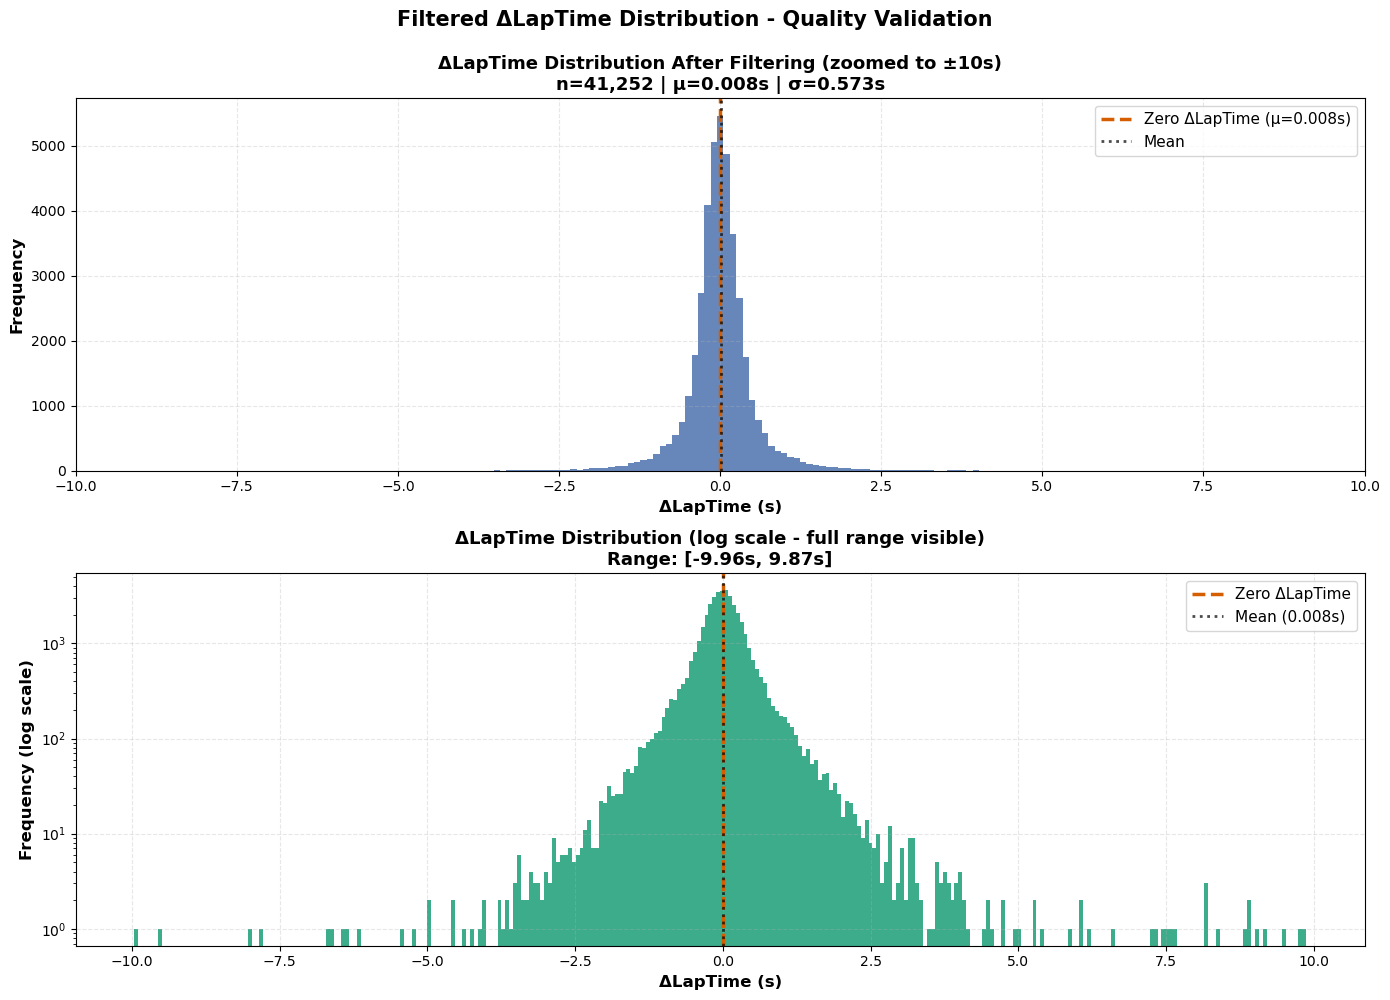


ΔLapTime Summary:
  Transitions: 41,252
  Mean: 0.0082s
  Std: 0.5733s
  Median: -0.0030s
  Range: [-9.960s, 9.865s]
  95th percentile: ±1.107s
  99th percentile: ±2.032s


 Delta LapTime Distribution Visualization (Outliers Removed)

Filtering: removed top/bottom 1.0% = 2.0% total
  Lower threshold: -1.528s
  Upper threshold: 1.699s
  Outliers removed: 826 (2.00%)
  Data retained: 40,426 (98.00%)

Figure saved to: figures/delta_laptime_distribution_filtered.pdf


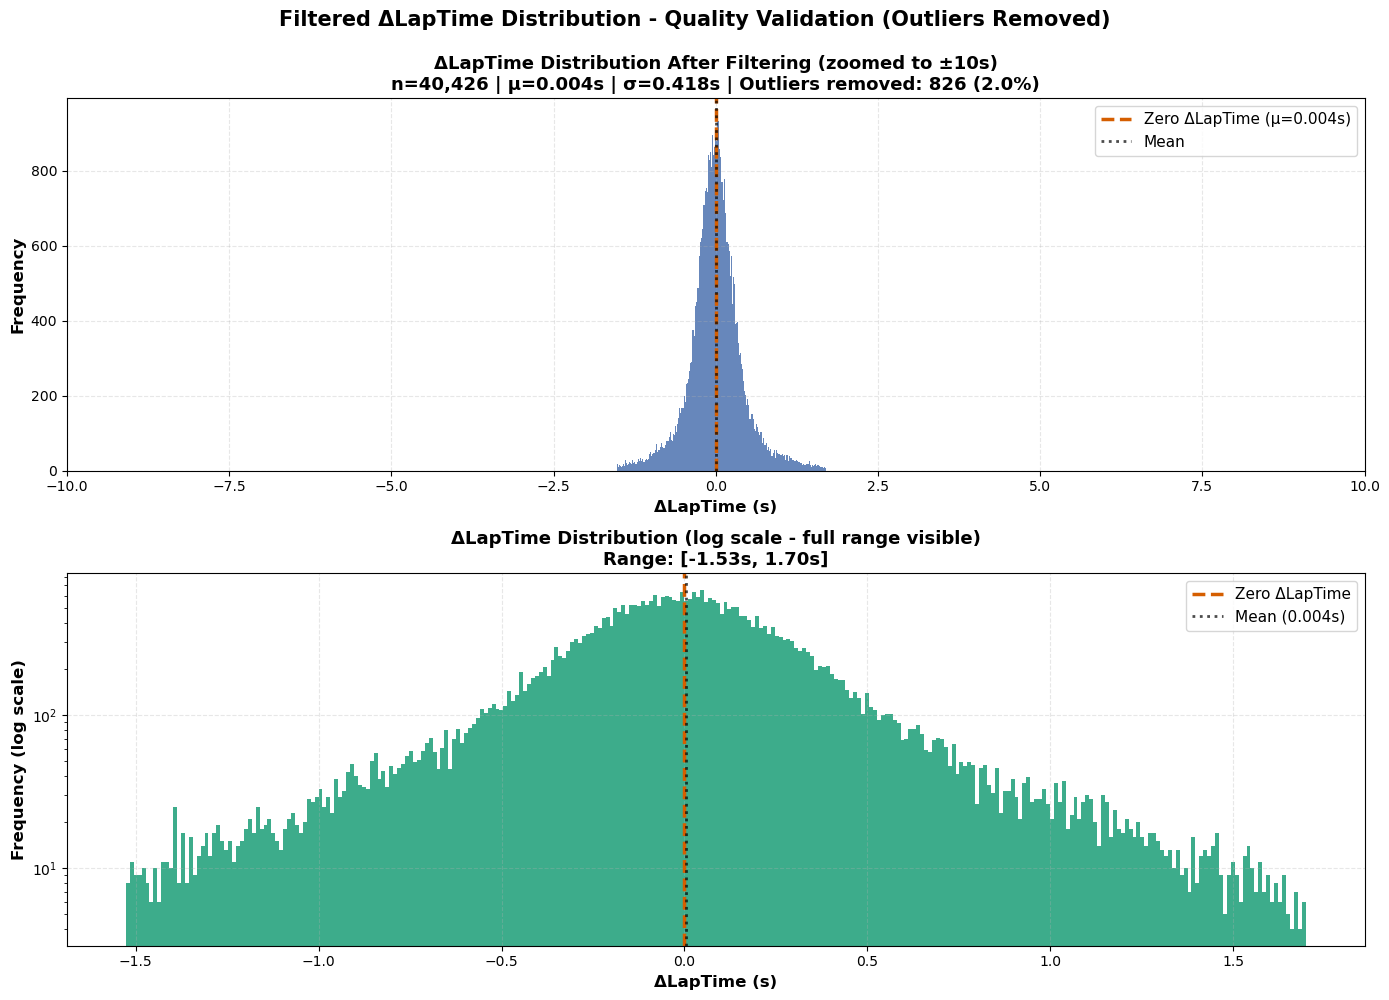


ΔLapTime Summary:
  Transitions: 40,426
  Mean: 0.0039s
  Std: 0.4185s
  Median: -0.0030s
  Range: [-1.527s, 1.698s]
  95th percentile: ±0.944s
  99th percentile: ±1.383s


In [8]:

def visualize_delta_distribution(df, delta_col="delta_laptime", outlier_percentile=None):
    """
    Visualize ΔLapTime distribution with optional outlier removal.
    
    Parameters:
    -----------
    df : DataFrame
        Data with delta_laptime column
    delta_col : str
        Column name for delta values
    outlier_percentile : float or None
        If None: show full data
        If float: remove top/bottom percentile (e.g., 0.005 = 0.5% each tail, 1% total)
    """

    # Create figures folder if it doesn't exist
    figures_dir = "figures"
    os.makedirs(figures_dir, exist_ok=True)
    
    x_full = df[delta_col].dropna()
    
    # Apply outlier filtering if requested
    if outlier_percentile is not None:
        lower_thresh = x_full.quantile(outlier_percentile)
        upper_thresh = x_full.quantile(1 - outlier_percentile)
        x = x_full[(x_full >= lower_thresh) & (x_full <= upper_thresh)]
        n_outliers = len(x_full) - len(x)


        print(f"\n" + "="*90)
        print("\n Delta LapTime Distribution Visualization (Outliers Removed)")

        print(f"\nFiltering: removed top/bottom {outlier_percentile*100:.1f}% = {outlier_percentile*200:.1f}% total")
        print(f"  Lower threshold: {lower_thresh:.3f}s")
        print(f"  Upper threshold: {upper_thresh:.3f}s")
        print(f"  Outliers removed: {n_outliers:,} ({n_outliers/len(x_full)*100:.2f}%)")
        print(f"  Data retained: {len(x):,} ({len(x)/len(x_full)*100:.2f}%)")
        
        title_suffix = f"Outliers removed: {n_outliers:,} ({outlier_percentile*200:.1f}%)"
        main_title = "Filtered ΔLapTime Distribution - Quality Validation (Outliers Removed)"
        filename = "delta_laptime_distribution_filtered.pdf"
    else:
        x = x_full
        n_outliers = 0
        

        print(f"\n Delta LapTime Distribution Visualization")

        
        title_suffix = ""
        main_title = "Filtered ΔLapTime Distribution - Quality Validation"
        filename = "delta_laptime_distribution.pdf"
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Color palette
    color_main = "#4C72B0"      # blue
    color_zero = "#D55E00"      # red/orange
    color_green = "#1B9E77"     # green
    
    # Plot 1: Zoomed view (±10s)
    axes[0].hist(x, bins=200, color=color_main, edgecolor="none", alpha=0.85)
    axes[0].axvline(0, color=color_zero, linestyle="--", linewidth=2.5, 
                    label=f"Zero ΔLapTime (μ={x.mean():.3f}s)")
    axes[0].axvline(x.mean(), color="black", linestyle=":", linewidth=2, 
                    label=f"Mean", alpha=0.7)
    axes[0].set_xlim(-10, 10)
    axes[0].set_xlabel("ΔLapTime (s)", fontsize=12, fontweight="bold")
    axes[0].set_ylabel("Frequency", fontsize=12, fontweight="bold")
    
    # Dynamic title based on outlier removal
    if title_suffix:
        title = (f"ΔLapTime Distribution After Filtering (zoomed to ±10s)\n"
                f"n={len(x):,} | μ={x.mean():.3f}s | σ={x.std():.3f}s | {title_suffix}")
    else:
        title = (f"ΔLapTime Distribution After Filtering (zoomed to ±10s)\n"
                f"n={len(x):,} | μ={x.mean():.3f}s | σ={x.std():.3f}s")
    
    axes[0].set_title(title, fontsize=13, fontweight="bold")
    axes[0].legend(fontsize=11, loc='upper right')
    axes[0].grid(True, alpha=0.3, linestyle="--")
    
    # Plot 2: Log scale (full range - see tails)
    axes[1].hist(x, bins=300, color=color_green, edgecolor="none", alpha=0.85)
    axes[1].axvline(0, color=color_zero, linestyle="--", linewidth=2.5, 
                    label="Zero ΔLapTime")
    axes[1].axvline(x.mean(), color="black", linestyle=":", linewidth=2, 
                    label=f"Mean ({x.mean():.3f}s)", alpha=0.7)
    axes[1].set_xlabel("ΔLapTime (s)", fontsize=12, fontweight="bold")
    axes[1].set_ylabel("Frequency (log scale)", fontsize=12, fontweight="bold")
    axes[1].set_yscale("log")
    axes[1].set_title(
        f"ΔLapTime Distribution (log scale - full range visible)\n"
        f"Range: [{x.min():.2f}s, {x.max():.2f}s]",
        fontsize=13, fontweight="bold"
    )
    axes[1].legend(fontsize=11, loc='upper right')
    axes[1].grid(True, alpha=0.3, linestyle="--")
    
    fig.suptitle(main_title, fontsize=15, fontweight="bold", y=0.995)
    plt.tight_layout()
    
    # Save figure as PDF
    pdf_path = os.path.join(figures_dir, filename)
    fig.savefig(pdf_path, format='pdf', bbox_inches='tight', dpi=300)
    print(f"\nFigure saved to: {pdf_path}")
    
    plt.show()
    
    # Print summary
    print(f"\nΔLapTime Summary:")
    print(f"  Transitions: {len(x):,}")
    print(f"  Mean: {x.mean():.4f}s")
    print(f"  Std: {x.std():.4f}s")
    print(f"  Median: {x.median():.4f}s")
    print(f"  Range: [{x.min():.3f}s, {x.max():.3f}s]")
    print(f"  95th percentile: ±{x.abs().quantile(0.95):.3f}s")
    print(f"  99th percentile: ±{x.abs().quantile(0.99):.3f}s")


# Full data (no outlier removal)
visualize_delta_distribution(df_pairs, delta_col="delta_laptime", outlier_percentile=None)

# Filtered data (remove top/bottom 0.5% = 1% total)
visualize_delta_distribution(df_pairs, delta_col="delta_laptime", outlier_percentile=0.01)

In [9]:

print(f"\n Applying oulier filtering")

# Remove top/bottom 0.5% (1% total)
outlier_percentile = 0.01
delta_full = df_pairs['delta_laptime'].dropna()
lower_thresh = delta_full.quantile(outlier_percentile)
upper_thresh = delta_full.quantile(1 - outlier_percentile)

# Filter dataset
df_pairs_original = df_pairs.copy()  # Keep original for reference
df_pairs = df_pairs[(df_pairs['delta_laptime'] >= lower_thresh) & 
                    (df_pairs['delta_laptime'] <= upper_thresh)].copy()

n_removed = len(df_pairs_original) - len(df_pairs)
print(f" Removed {n_removed:,} outlier transitions ({n_removed/len(df_pairs_original)*100:.2f}%)")

df_pairs.to_excel('csv_output/Filtered_03_with_deltas.xlsx', index=False)
print(f"\n✓ Saved filtered dataset: csv_output/Filtered_03_with_deltas.xlsx")

n_removed = len(df_pairs_original) - len(df_pairs)



 Applying oulier filtering
 Removed 826 outlier transitions (2.00%)

✓ Saved filtered dataset: csv_output/Filtered_03_with_deltas.xlsx


Autocorrelation analysis of ΔLapTime

   a) Computing ACF of ΔLapTime...

   b) Fitting baseline model: ΔLapTime ~ LapTime (current)...
   Baseline model:
   - Coefficient (LapTime): -0.001070
   - Intercept: 0.099528
   - R² score: 0.000689
   - Mean residual: -0.000000
   - Std residual: 0.418302

 Outlier analysis
   Outlier threshold (bottom 0.5%): |ΔLapTime| <= 0.002s
   Outlier threshold (top 0.5%): |ΔLapTime| >= 1.479s
   Total outliers: 455 (1.13%)
   Outlier range: [-1.527s, 1.698s]


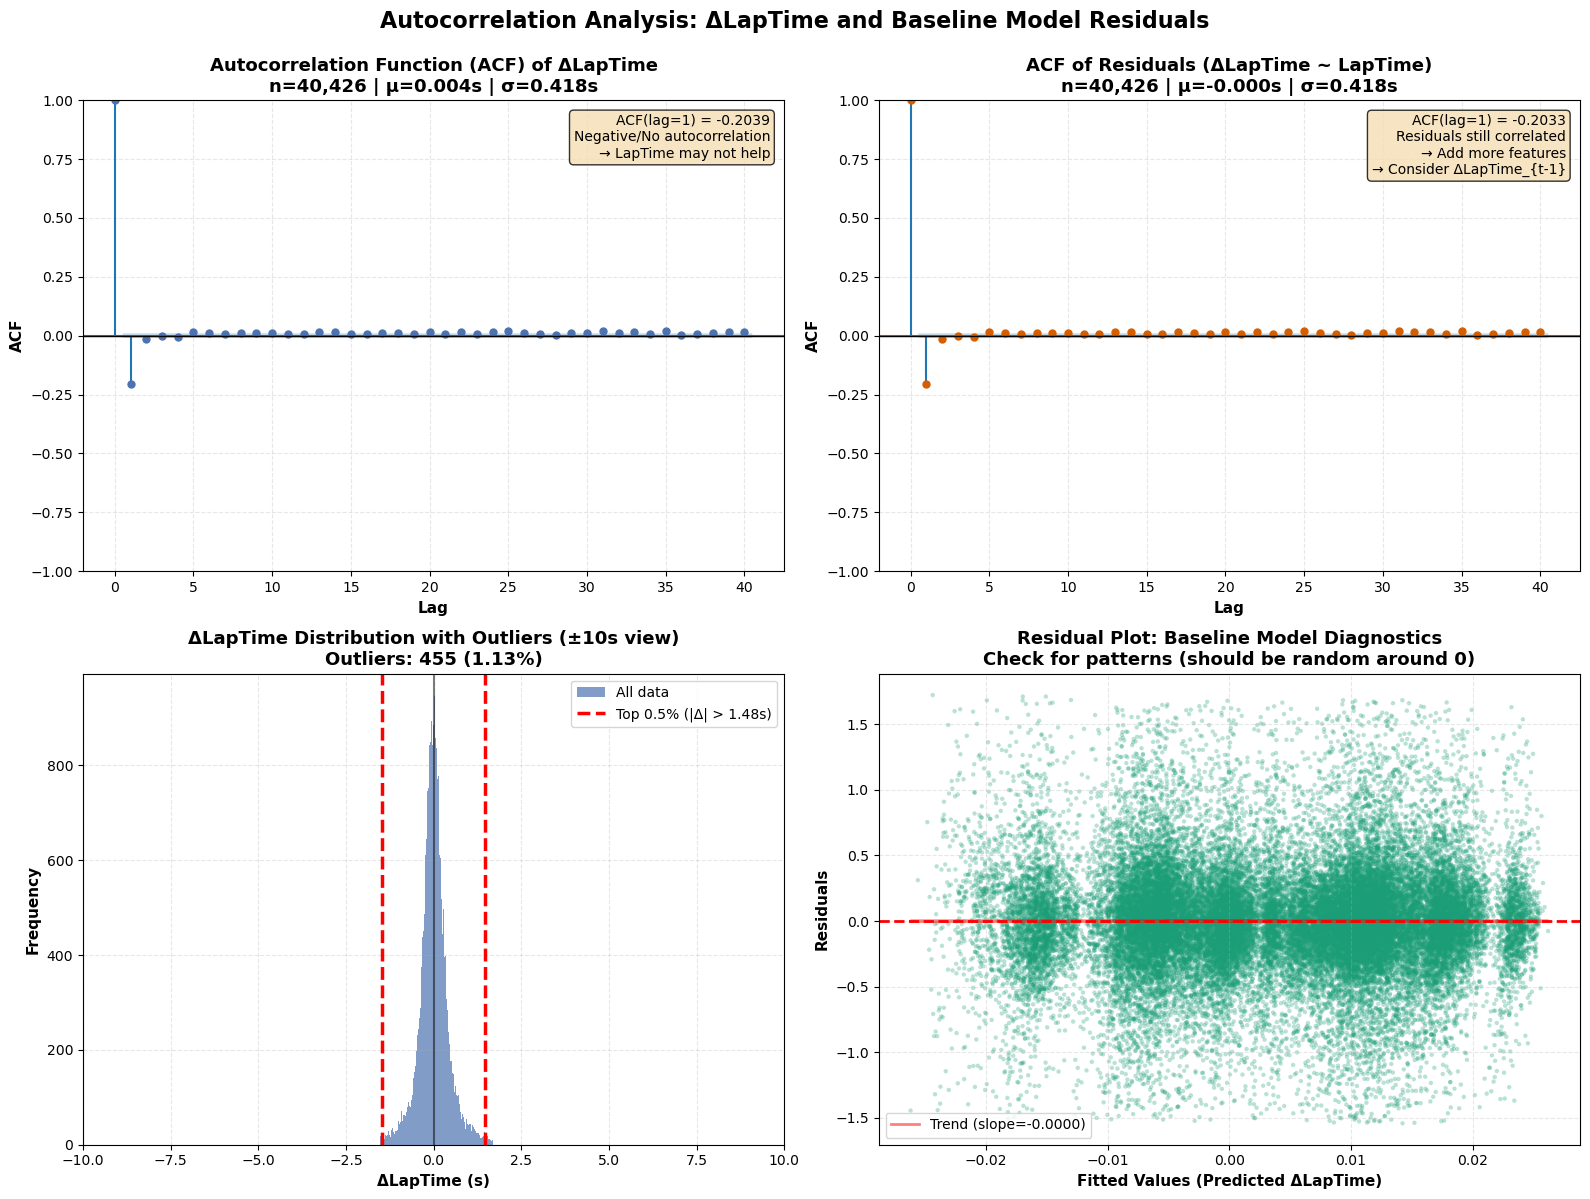

1. LapTime (current): REMOVE (ACF = -0.2039)
2. Add ΔLapTime_{t-1}: NO
3. Residual autocorrelation: HIGH - Add features
4. Outliers detected: 455


In [10]:
print("Autocorrelation analysis of ΔLapTime")

#ACF of ΔLapTime
print("\n   a) Computing ACF of ΔLapTime...")
delta_laptime = df_pairs['delta_laptime'].dropna().values

# Simple baseline model: ΔLapTime ~ LapTime (current lap)
print("\n   b) Fitting baseline model: ΔLapTime ~ LapTime (current)...")

# Prepare data for baseline model
df_baseline = df_pairs[['delta_laptime', 'LapTime']].dropna()
X_baseline = df_baseline[['LapTime']].values
y_baseline = df_baseline['delta_laptime'].values

# Fit simple linear regression
baseline_model = LinearRegression()
baseline_model.fit(X_baseline, y_baseline)
y_pred = baseline_model.predict(X_baseline)
residuals = y_baseline - y_pred

print(f"   Baseline model:")
print(f"   - Coefficient (LapTime): {baseline_model.coef_[0]:.6f}")
print(f"   - Intercept: {baseline_model.intercept_:.6f}")
print(f"   - R² score: {baseline_model.score(X_baseline, y_baseline):.6f}")
print(f"   - Mean residual: {residuals.mean():.6f}")
print(f"   - Std residual: {residuals.std():.6f}")

# 5. Outlier analysis
print("\n Outlier analysis")
abs_delta = df_pairs['delta_laptime'].abs()
threshold_bottom = abs_delta.quantile(0.005)  # Bottom 0.5%
threshold_top = abs_delta.quantile(0.995)     # Top 0.5%

outliers = df_pairs[(abs_delta <= threshold_bottom) | (abs_delta >= threshold_top)]
print(f"   Outlier threshold (bottom 0.5%): |ΔLapTime| <= {threshold_bottom:.3f}s")
print(f"   Outlier threshold (top 0.5%): |ΔLapTime| >= {threshold_top:.3f}s")
print(f"   Total outliers: {len(outliers)} ({len(outliers)/len(df_pairs)*100:.2f}%)")
print(f"   Outlier range: [{df_pairs['delta_laptime'].min():.3f}s, {df_pairs['delta_laptime'].max():.3f}s]")

# Create comprehensive ACF plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: ACF of ΔLapTime

plot_acf(delta_laptime, lags=40, ax=axes[0, 0], alpha=0.05, color='#4C72B0')
axes[0, 0].set_title('Autocorrelation Function (ACF) of ΔLapTime\n'
                     f'n={len(delta_laptime):,} | μ={delta_laptime.mean():.3f}s | σ={delta_laptime.std():.3f}s',
                     fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Lag', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('ACF', fontsize=11, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, linestyle='--')
axes[0, 0].axhline(0, color='black', linestyle='-', linewidth=1)

# Add interpretation text
acf_lag1 = acf(delta_laptime, nlags=1)[1]
interpretation_1 = f"ACF(lag=1) = {acf_lag1:.4f}\n"
if acf_lag1 > 0.1:
    interpretation_1 += "Strong positive autocorrelation\n→ Keep LapTime (current)\n→ Consider adding ΔLapTime_{t-1}"
elif acf_lag1 > 0:
    interpretation_1 += "Weak positive autocorrelation\n→ Keep LapTime (current)"
else:
    interpretation_1 += "Negative/No autocorrelation\n→ LapTime may not help"
    
axes[0, 0].text(0.98, 0.97, interpretation_1,
               transform=axes[0, 0].transAxes,
               verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
               fontsize=10)

# Plot 2: ACF of Residuals

plot_acf(residuals, lags=40, ax=axes[0, 1], alpha=0.05, color='#D55E00')
axes[0, 1].set_title('ACF of Residuals (ΔLapTime ~ LapTime)\n'
                     f'n={len(residuals):,} | μ={residuals.mean():.3f}s | σ={residuals.std():.3f}s',
                     fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Lag', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('ACF', fontsize=11, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, linestyle='--')
axes[0, 1].axhline(0, color='black', linestyle='-', linewidth=1)

# Add interpretation text
acf_res_lag1 = acf(residuals, nlags=1)[1]
interpretation_2 = f"ACF(lag=1) = {acf_res_lag1:.4f}\n"
if abs(acf_res_lag1) < 0.05:
    interpretation_2 += "Residuals are white noise\n→ Model captures autocorr.\n→ Good baseline"
else:
    interpretation_2 += "Residuals still correlated\n→ Add more features\n→ Consider ΔLapTime_{t-1}"
    
axes[0, 1].text(0.98, 0.97, interpretation_2,
               transform=axes[0, 1].transAxes,
               verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
               fontsize=10)

# Plot 3: Histogram of ΔLapTime with outlier markers

axes[1, 0].hist(delta_laptime, bins=200, color='#4C72B0', alpha=0.7, edgecolor='none', label='All data')
axes[1, 0].axvline(threshold_top, color='red', linestyle='--', linewidth=2.5, 
                  label=f'Top 0.5% (|Δ| > {threshold_top:.2f}s)')
axes[1, 0].axvline(-threshold_top, color='red', linestyle='--', linewidth=2.5)
axes[1, 0].axvline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.5)
axes[1, 0].set_xlim(-10, 10)
axes[1, 0].set_xlabel('ΔLapTime (s)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 0].set_title(f'ΔLapTime Distribution with Outliers (±10s view)\n'
                     f'Outliers: {len(outliers):,} ({len(outliers)/len(df_pairs)*100:.2f}%)',
                     fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10, loc='upper right')
axes[1, 0].grid(True, alpha=0.3, linestyle='--')

# Plot 4: Residuals vs Fitted values (diagnostic)

axes[1, 1].scatter(y_pred, residuals, alpha=0.3, s=10, color='#1B9E77', edgecolors='none')
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Fitted Values (Predicted ΔLapTime)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Residuals', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Residual Plot: Baseline Model Diagnostics\n'
                     f'Check for patterns (should be random around 0)',
                     fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, linestyle='--')

# Add trend line
# Add trend line
from scipy.stats import linregress as scipy_linregress
slope, intercept, r_value, p_value, std_err = scipy_linregress(y_pred, residuals)
line = slope * y_pred + intercept
axes[1, 1].plot(y_pred, line, 'r-', linewidth=2, alpha=0.5, 
               label=f'Trend (slope={slope:.4f})')
axes[1, 1].legend(fontsize=10)

fig.suptitle('Autocorrelation Analysis: ΔLapTime and Baseline Model Residuals',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('figures/autocorrelation_analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()


print(f"1. LapTime (current): {'KEEP' if acf_lag1 > 0 else 'REMOVE'} (ACF = {acf_lag1:.4f})")
print(f"2. Add ΔLapTime_{{t-1}}: {'YES' if acf_lag1 > 0.1 else 'MAYBE' if acf_lag1 > 0 else 'NO'}")
print(f"3. Residual autocorrelation: {'LOW - Good model' if abs(acf_res_lag1) < 0.05 else 'HIGH - Add features'}")
print(f"4. Outliers detected: {len(outliers):,}")


<h1><center> Delta Lap time distribution by tyre compound </center></h1>

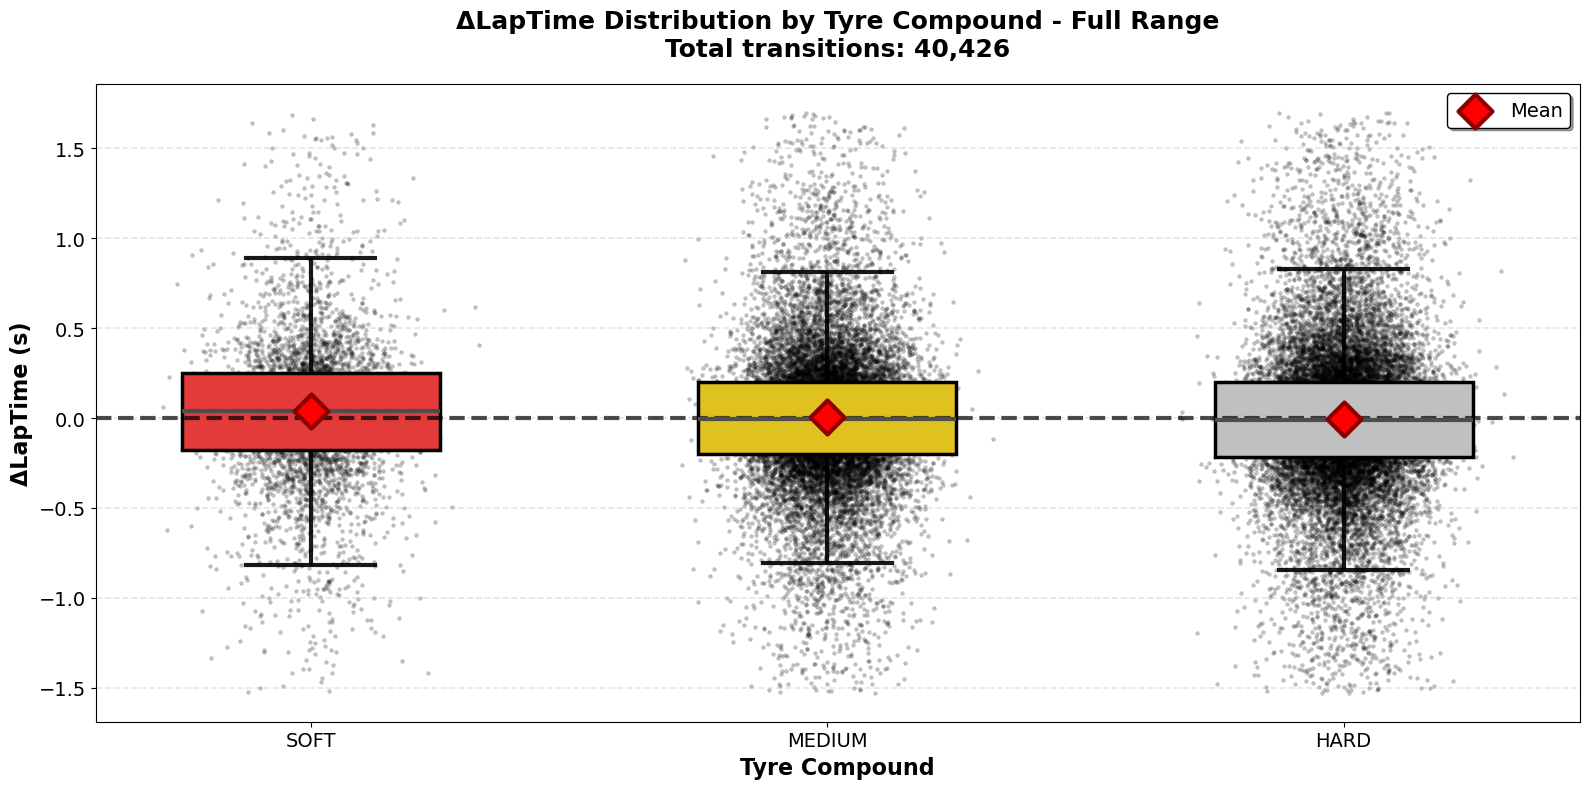


Full Range Statistics
            mean  median     std  count
Compound                               
HARD     -0.0039  -0.010  0.4275  19379
MEDIUM    0.0037  -0.005  0.4077  16641
SOFT      0.0390   0.040  0.4167   4406


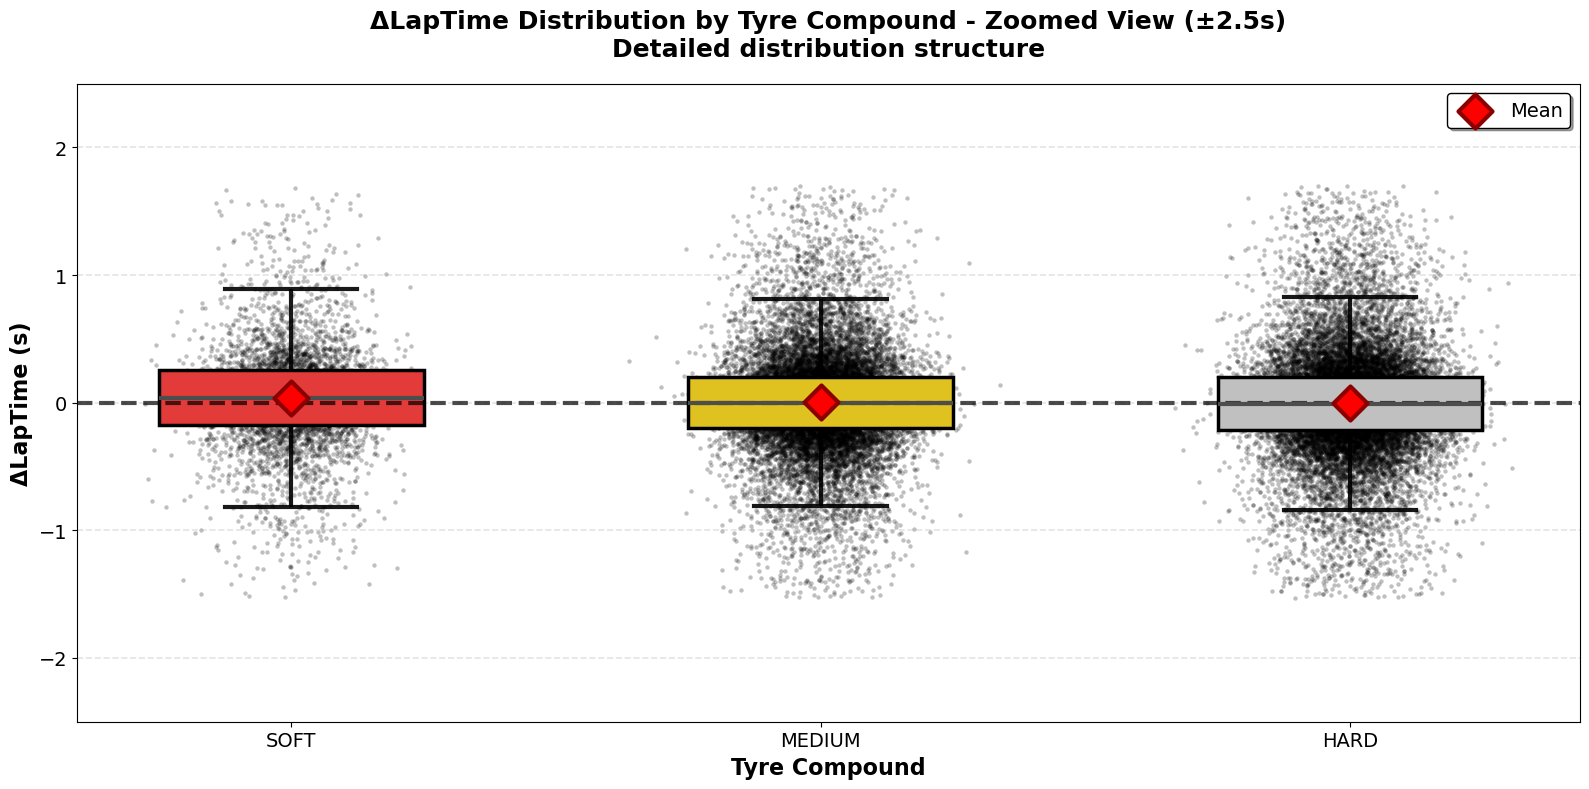

In [11]:

def plot_delta_full_range(df, delta_col="delta_laptime", sample_points=40000):
    """
    Full range boxplot - see all extreme values.
    """
    compounds = ["SOFT", "MEDIUM", "HARD"]
    df = df[df["Compound"].isin(compounds)].copy()
    
    palette = {"SOFT": "#FF1E1E", "MEDIUM": "#FFD700", "HARD": "#C0C0C0"}
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    stats = df.groupby("Compound")[delta_col].agg(['mean', 'median', 'std', 'count'])
    
    # Boxplot
    bp = sns.boxplot(
        data=df, x="Compound", y=delta_col, order=compounds,
        palette=palette, width=0.5, linewidth=3,
        showfliers=False, ax=ax,
        whiskerprops=dict(color='black', linewidth=3, alpha=0.9),  # WHISKERS
        capprops=dict(color='black', linewidth=3, alpha=0.9) 
    )
    
    for patch in bp.patches:
        patch.set_edgecolor('black')
        patch.set_linewidth(2.5)
    
    # Sample and plot points
    for i, comp in enumerate(compounds):
        comp_data = df[df["Compound"] == comp][delta_col]
        if len(comp_data) > sample_points:
            sample_idx = np.random.choice(len(comp_data), sample_points, replace=False)
            plot_data = comp_data.iloc[sample_idx]
        else:
            plot_data = comp_data
        
        x_jitter = np.random.normal(i, 0.08, size=len(plot_data))
        ax.scatter(x_jitter, plot_data, color='black', s=10, alpha=0.25, linewidths=0)
    
    # Mean overlay
    for i, comp in enumerate(compounds):
        ax.scatter(i, stats.loc[comp, 'mean'], 
                  color='red', marker='D', s=300,
                  zorder=10, edgecolor='darkred', linewidth=3,
                  label='Mean' if i == 0 else '')
    
    ax.axhline(0, color='black', linestyle='--', linewidth=3, alpha=0.7)
    
    ax.set_ylabel("ΔLapTime (s)", fontsize=16, fontweight='bold')
    ax.set_xlabel("Tyre Compound", fontsize=16, fontweight='bold')
    ax.set_title(
        f"ΔLapTime Distribution by Tyre Compound - Full Range\n"
        f"Total transitions: {len(df):,}",
        fontsize=18, fontweight='bold', pad=20
    )
    ax.legend(fontsize=14, loc='upper right', frameon=True, edgecolor='black', shadow=True)
    ax.grid(axis='y', linestyle='--', alpha=0.35, linewidth=1.2)
    ax.tick_params(labelsize=14)
    
    plt.tight_layout()
    plt.savefig('figures/delta_full_range_by_compound.pdf', dpi=300)
    plt.show()
    

    print(f"\nFull Range Statistics")
    print(stats.round(4))




def plot_delta_zoomed(df, delta_col="delta_laptime", sample_points=40000):
    """
    Zoomed boxplot - detailed view of main distribution.
    """
    compounds = ["SOFT", "MEDIUM", "HARD"]
    df = df[df["Compound"].isin(compounds)].copy()
    
    palette = {"SOFT": "#FF1E1E", "MEDIUM": "#FFD700", "HARD": "#C0C0C0"}
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    stats = df.groupby("Compound")[delta_col].agg(['mean', 'median', 'std', 'count'])
    
    # Boxplot
    bp = sns.boxplot(
        data=df, x="Compound", y=delta_col, order=compounds,
        palette=palette, width=0.5, linewidth=3,
        showfliers=False, ax=ax,
        whiskerprops=dict(color='black', linewidth=3, alpha=0.9),  # WHISKERS
        capprops=dict(color='black', linewidth=3, alpha=0.9)
    )
    
    for patch in bp.patches:
        patch.set_edgecolor('black')
        patch.set_linewidth(2.5)
    
    # Sample and plot points
    for i, comp in enumerate(compounds):
        comp_data = df[df["Compound"] == comp][delta_col]
        if len(comp_data) > sample_points:
            sample_idx = np.random.choice(len(comp_data), sample_points, replace=False)
            plot_data = comp_data.iloc[sample_idx]
        else:
            plot_data = comp_data
        
        x_jitter = np.random.normal(i, 0.08, size=len(plot_data))
        ax.scatter(x_jitter, plot_data, color='black', s=10, alpha=0.25, linewidths=0)
    
    # Mean overlay
    for i, comp in enumerate(compounds):
        ax.scatter(i, stats.loc[comp, 'mean'], 
                  color='red', marker='D', s=300,
                  zorder=10, edgecolor='darkred', linewidth=3,
                  label='Mean' if i == 0 else '')
    
    ax.axhline(0, color='black', linestyle='--', linewidth=3, alpha=0.7)
    
    # Zoomed view
    ax.set_ylim(-2.5, 2.5)
    ax.set_ylabel("ΔLapTime (s)", fontsize=16, fontweight='bold')
    ax.set_xlabel("Tyre Compound", fontsize=16, fontweight='bold')
    ax.set_title(
        f"ΔLapTime Distribution by Tyre Compound - Zoomed View (±2.5s)\n"
        f"Detailed distribution structure",
        fontsize=18, fontweight='bold', pad=20
    )
    ax.legend(fontsize=14, loc='upper right', frameon=True, edgecolor='black', shadow=True)
    ax.grid(axis='y', linestyle='--', alpha=0.35, linewidth=1.2)
    ax.tick_params(labelsize=14)
    
    plt.tight_layout()
    plt.savefig('figures/delta_zoomed_by_compound.pdf', dpi=300)
    plt.show()
    

plot_delta_full_range(df_pairs, delta_col="delta_laptime", sample_points=40000)

plot_delta_zoomed(df_pairs, delta_col="delta_laptime", sample_points=40000)

<h1><center> Tyre degradation by compound  </center></h1>

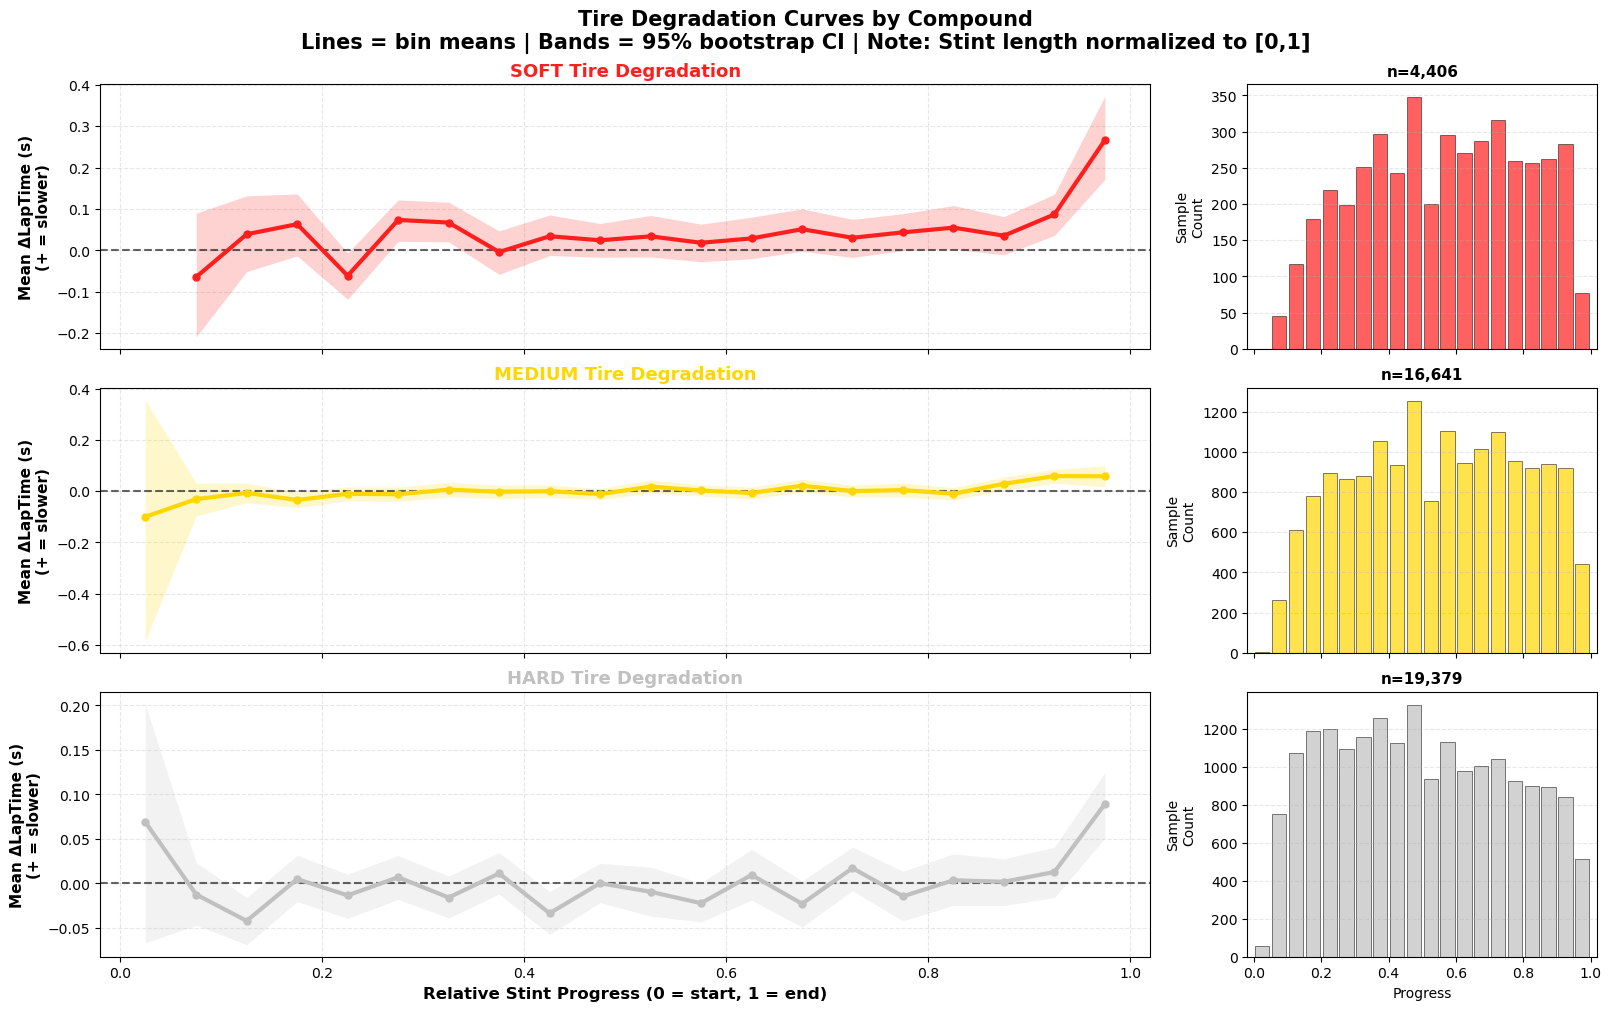

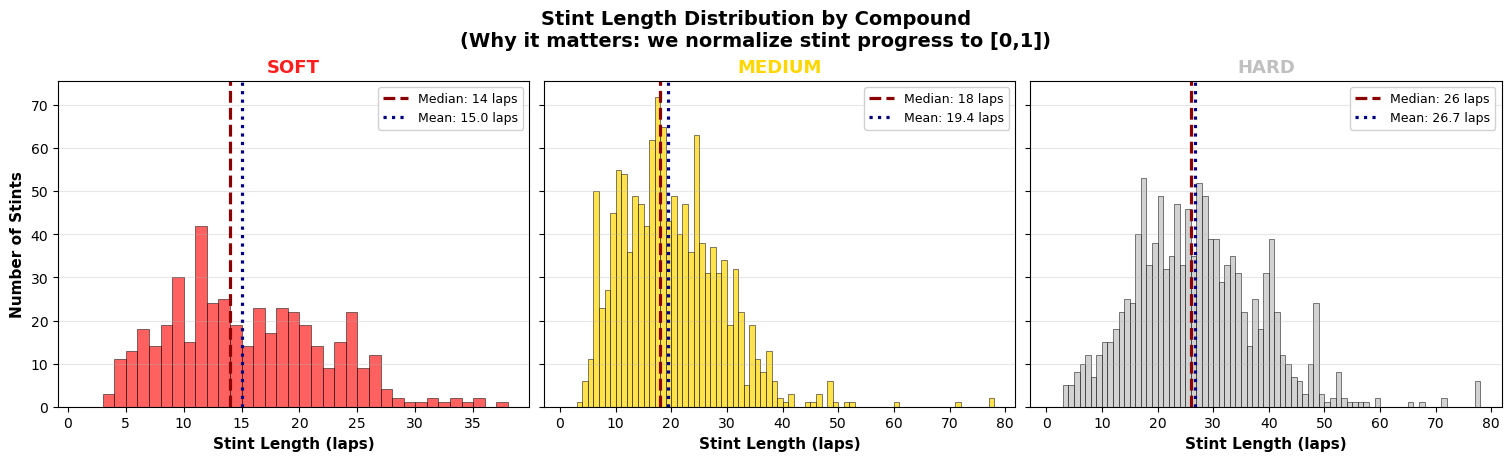


ΔLapTime: Early vs Late by Compound

Compound   Early (0-10%)   Late (90-100%)  Δ (Late-Early)  Total n   
SOFT       -0.0639s        +0.1769s        +0.2409s           4,406
MEDIUM     -0.0655s        +0.0584s        +0.1240s          16,641
HARD       +0.0283s        +0.0511s        +0.0227s          19,379


In [12]:

# Helpers
def _bootstrap_ci_mean(x, n_boot=2000, alpha=0.05, seed=42):
    """Return (mean, lower, upper) via bootstrap percentile CI."""
    x = np.asarray(pd.Series(x).dropna(), float)
    if x.size == 0:
        return np.nan, np.nan, np.nan
    rng = np.random.default_rng(seed)
    boots = rng.choice(x, size=(n_boot, x.size), replace=True).mean(axis=1)
    lo, hi = np.percentile(boots, [100*alpha/2, 100*(1-alpha/2)])
    return float(x.mean()), float(lo), float(hi)

def summarize_degradation(df, bins=np.linspace(0, 1, 21)):
    """
    Bin rel_stint_progress and compute mean ΔLapTime with 95% CI and counts per compound.
    Returns a tidy summary DataFrame.
    """
    keep = df[df["Compound"].isin(["SOFT","MEDIUM","HARD"])].copy()
    keep["bin"] = pd.cut(keep["rel_stint_progress"], bins=bins, include_lowest=True, right=True)
    mids = keep["bin"].cat.categories.mid
    rows = []
    for comp, g in keep.groupby("Compound", observed=True):
        for i, cat in enumerate(g["bin"].cat.categories):
            vals = g.loc[g["bin"] == cat, "delta_laptime"]
            mean, lo, hi = _bootstrap_ci_mean(vals)
            rows.append({
                "Compound": comp,
                "bin": cat,
                "mid": mids[i],
                "mean": mean, "lo": lo, "hi": hi,
                "n": int(vals.notna().sum())
            })
    out = pd.DataFrame(rows)
    return out[out["n"] > 0].sort_values(["Compound","mid"]).reset_index(drop=True)

# Plots
def plot_degradation_curves(summary, bins=np.linspace(0,1,21)):
    """
    Figure 1: Degradation curves per compound (left) + sample counts (right).
    Simple, readable, no extra stats.
    """
    colors = {"SOFT":"#FF1E1E", "MEDIUM":"#FFD700", "HARD":"#C0C0C0"}
    compounds = ["SOFT","MEDIUM","HARD"]
    fig = plt.figure(figsize=(16, 10), constrained_layout=True)
    gs = GridSpec(3, 2, figure=fig, 
                  width_ratios=[3, 1], height_ratios=[1, 1, 1])
    
    for r, comp in enumerate(compounds):
        s = summary[summary["Compound"] == comp]
        ax_curve = fig.add_subplot(gs[r, 0])
        ax_count = fig.add_subplot(gs[r, 1])
        
        # Curve with 95% CI
        ax_curve.plot(s["mid"], s["mean"], lw=3, color=colors[comp], marker='o', ms=5, zorder=3)
        ax_curve.fill_between(s["mid"], s["lo"], s["hi"], color=colors[comp], alpha=0.20, zorder=2, lw=0)
        ax_curve.axhline(0, color="black", ls="--", lw=1.5, alpha=0.6)
        ax_curve.set_xlim(-0.02, 1.02)
        ax_curve.set_ylabel("Mean ΔLapTime (s)\n(+ = slower)", fontsize=11, fontweight='bold')
        ax_curve.set_title(f"{comp} Tire Degradation", fontsize=13, color=colors[comp], fontweight="bold")
        ax_curve.grid(True, alpha=0.3, ls="--")
        if r == 2:
            ax_curve.set_xlabel("Relative Stint Progress (0 = start, 1 = end)", fontsize=12, fontweight='bold')
        else:
            ax_curve.set_xticklabels([])
        
        # Counts (bar height = n per bin)
        width = (bins[1]-bins[0]) * 0.85
        ax_count.bar(s["mid"], s["n"], width=width, color=colors[comp], alpha=0.7,
                     edgecolor='black', linewidth=0.5)
        ax_count.set_xlim(-0.02, 1.02)
        ax_count.set_ylabel("Sample\nCount", fontsize=10)
        ax_count.set_title(f"n={s['n'].sum():,}", fontsize=11, fontweight="bold")
        ax_count.grid(True, axis="y", alpha=0.3, ls="--")
        ax_count.ticklabel_format(style='plain', axis='y')
        if r == 2:
            ax_count.set_xlabel("Progress", fontsize=10)
        else:
            ax_count.set_xticklabels([])
    
    fig.suptitle("Tire Degradation Curves by Compound\n"
                 "Lines = bin means | Bands = 95% bootstrap CI | "
                 "Note: Stint length normalized to [0,1]",
                 fontsize=15, fontweight='bold')
    
    plt.savefig('figures/degradation_curves_separated.pdf', dpi=300, bbox_inches='tight')
    plt.show()

def plot_stint_length_distribution(df):
    """
    Figure 2: Stint-length histograms per compound (context for normalization).
    """
    colors = {"SOFT":"#FF1E1E", "MEDIUM":"#FFD700", "HARD":"#C0C0C0"}
    compounds = ["SOFT","MEDIUM","HARD"]
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5), sharey=True, constrained_layout=True)
    
    for ax, comp in zip(axes, compounds):
        d = df[df["Compound"] == comp]
        if d.empty:
            ax.axis("off")
            continue
        
        # unique stint lengths
        stints = d.groupby(["year","round","RacingNumber","Stint"])["stint_length"].first()
        bins = range(1, int(stints.max())+2)
        ax.hist(stints, bins=bins, color=colors[comp], alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.axvline(stints.median(), color='darkred', ls='--', lw=2.3, label=f"Median: {stints.median():.0f} laps")
        ax.axvline(stints.mean(),   color='navy',    ls=':',  lw=2.3, label=f"Mean: {stints.mean():.1f} laps")
        ax.set_title(comp, fontsize=13, fontweight="bold", color=colors[comp])
        ax.set_xlabel("Stint Length (laps)", fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        ax.legend(fontsize=9, framealpha=0.9)
    
    axes[0].set_ylabel("Number of Stints", fontsize=11, fontweight='bold')
    fig.suptitle("Stint Length Distribution by Compound\n(Why it matters: we normalize stint progress to [0,1])",
                 fontsize=14, fontweight='bold')
    
    plt.savefig('figures/stint_length_distribution.pdf', dpi=300, bbox_inches='tight')
    plt.show()



# Build the summary once
_bins = np.linspace(0, 1, 21)  # 20 bins, 5%-wide each
summary = summarize_degradation(df_pairs, bins=_bins)

# Figure 1: degradation curves + counts
plot_degradation_curves(summary, bins=_bins)

# Figure 2: stint-length context
plot_stint_length_distribution(df_pairs)

# Print Early vs Late summary table

print(f"\nΔLapTime: Early vs Late by Compound")
print(f"\n{'Compound':<10} {'Early (0-10%)':<15} {'Late (90-100%)':<15} {'Δ (Late-Early)':<15} {'Total n':<10}")


for comp in ["SOFT", "MEDIUM", "HARD"]:
    s = summary[summary["Compound"] == comp]
    early = s.loc[s["mid"] <= 0.10, "mean"].mean()
    late = s.loc[s["mid"] >= 0.90, "mean"].mean()
    delta = (late - early) if np.isfinite(early) and np.isfinite(late) else np.nan
    n_tot = int(s["n"].sum())
    
    print(f"{comp:<10} {early:+.4f}s        {late:+.4f}s        {delta:+.4f}s        {n_tot:>8,}")


<h1><center> Weather influence on delta lap time  </center></h1>

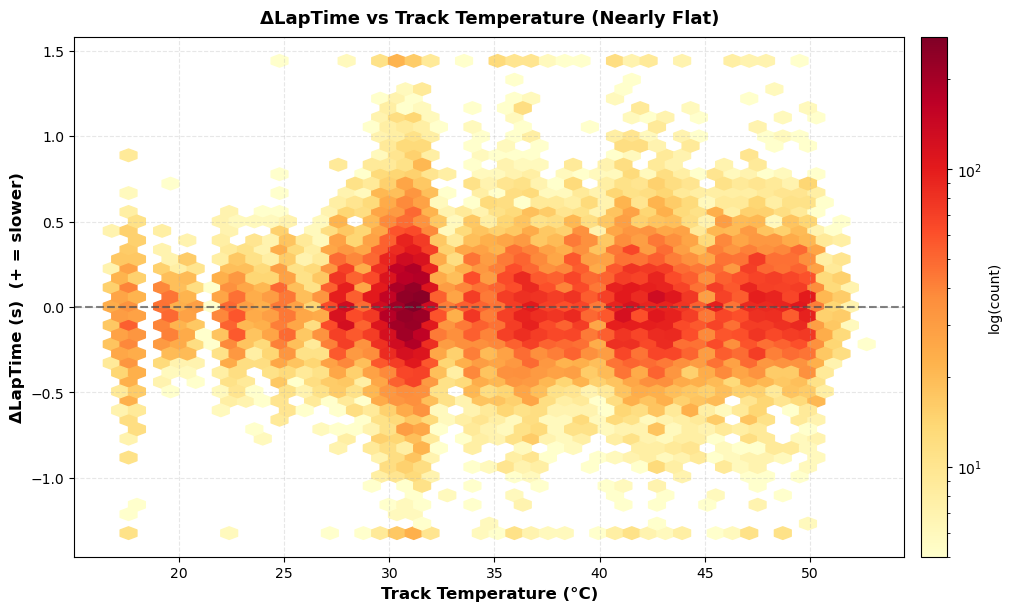

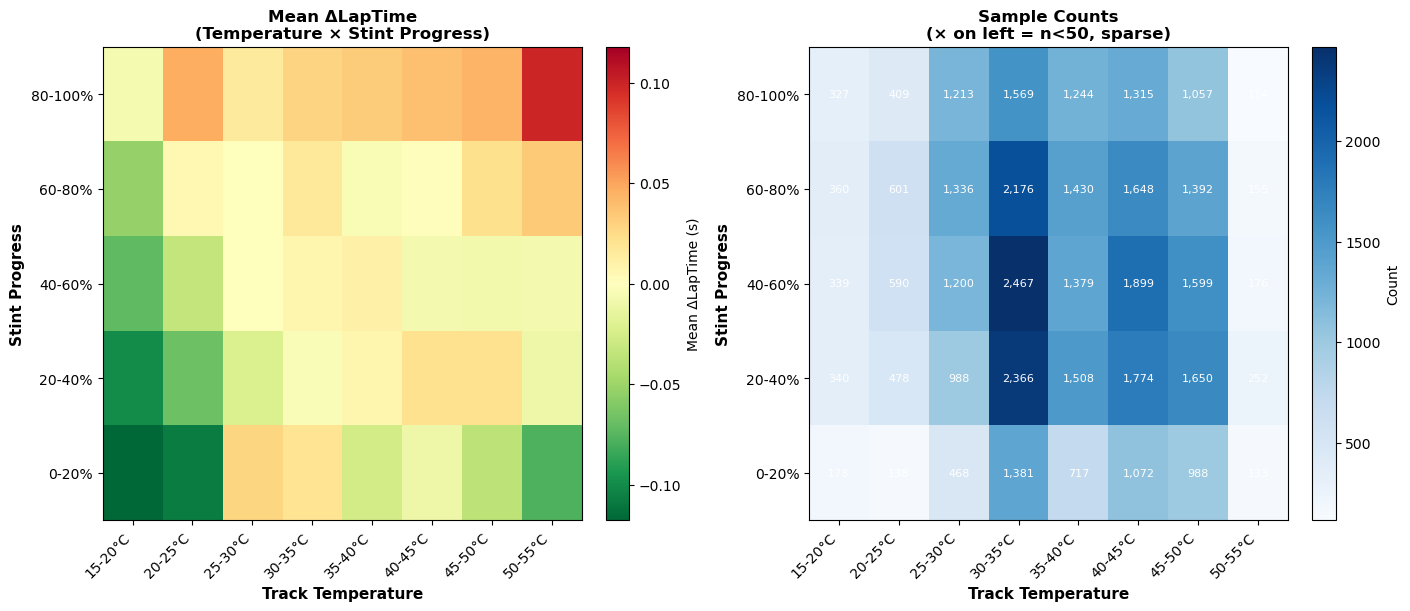


Slope: +0.0010 ± 0.0005 s/°C (n=40,426)


In [13]:

# Helpers 

def _clean(df, cols):
    """Drop rows with NaN in specified columns."""
    return df.dropna(subset=cols).copy()

def _winsor(x, p=0.005):
    """Clip extreme values for visual clarity."""
    lo, hi = x.quantile([p, 1-p])
    return x.clip(lo, hi)


# Panel A: Hexbin

def plot_hexbin_tracktemp(df, gridsize=45, show_slope=False):
    """
    Hexbin density plot: ΔLapTime vs Track Temperature.
    Shows temperature has negligible effect (nearly flat).
    
    Parameters:
    -----------
    show_slope : bool
        If True, add regression line (default: False for clean visual)
    
    Returns:
    --------
    slope, se, n : float, float, int
        Slope, standard error, sample size (for caption if needed)
    """
    d = _clean(df, ["delta_laptime", "TrackTemp"])
    y = _winsor(d["delta_laptime"], 0.005)
    x = d["TrackTemp"]
    
    fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
    hb = ax.hexbin(x, y, gridsize=gridsize, bins='log', mincnt=5, cmap='YlOrRd')
    cb = fig.colorbar(hb, ax=ax, pad=0.02)
    cb.set_label("log(count)", fontsize=10)
    
    ax.axhline(0, ls="--", c="0.3", lw=1.5, alpha=0.7, zorder=2)
    ax.set_xlabel("Track Temperature (°C)", fontsize=12, fontweight='bold')
    ax.set_ylabel("ΔLapTime (s)  (+ = slower)", fontsize=12, fontweight='bold')
    ax.set_title("ΔLapTime vs Track Temperature (Nearly Flat)", 
                 fontsize=13, fontweight='bold', pad=10)
    
    # Optional slope line
    if show_slope:
        m = ~x.isna() & ~y.isna()
        slope, intercept, r, p, se = linregress(x[m], y[m])
        xx = np.linspace(x.min(), x.max(), 100)
        ax.plot(xx, intercept + slope*xx, c="blue", lw=2, alpha=0.7, ls='--', zorder=3,
                label=f"Slope: {slope:+.4f} s/°C")
        ax.legend(fontsize=9, loc='upper left', framealpha=0.9)
    
    ax.grid(alpha=0.3, ls="--")
    plt.savefig('figures/weather_panel_A_hexbin.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Return stats for caption
    m = ~x.isna() & ~y.isna()
    slope, _, _, _, se = linregress(x[m], y[m])
    return slope, se, len(d)


# Interaction Heatmap

def plot_temp_stint_interaction(df):
    """
    Heatmap: Temperature × Stint Progress interaction.
    
    Left panel:  Mean ΔLapTime (color shows effect size)
    Right panel: Sample counts (blue = reliable, × = sparse)
    
    Shows: Vertical gradient >> horizontal gradient
           → Stint progress dominates over temperature
    """
    d = _clean(df, ["delta_laptime", "TrackTemp", "rel_stint_progress"])
    
    # Bin data
    temp_bins = pd.cut(d["TrackTemp"], bins=np.arange(15, 56, 5))
    prog_bins = pd.cut(d["rel_stint_progress"], bins=np.linspace(0, 1, 6))
    
    pivot = d.groupby([temp_bins, prog_bins])["delta_laptime"].mean().unstack()
    counts = d.groupby([temp_bins, prog_bins]).size().unstack()
    
    # Symmetric color scale for fair comparison
    vmax = max(abs(pivot.min().min()), abs(pivot.max().max()))
    vmin = -vmax
    
    fig, (ax, ax_count) = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
    
    # LEFT: Mean ΔLapTime 
    im = ax.imshow(pivot.T, aspect='auto', cmap='RdYlGn_r', origin='lower',
                   vmin=vmin, vmax=vmax)
    
    ax.set_yticks(range(len(pivot.columns)))
    ax.set_yticklabels([f"{int(iv.left*100)}-{int(iv.right*100)}%" 
                        for iv in pivot.columns])
    ax.set_xticks(range(len(pivot.index)))
    ax.set_xticklabels([f"{int(iv.left)}-{int(iv.right)}°C" 
                        for iv in pivot.index], rotation=45, ha='right')
    ax.set_xlabel("Track Temperature", fontsize=11, fontweight='bold')
    ax.set_ylabel("Stint Progress", fontsize=11, fontweight='bold')
    ax.set_title("Mean ΔLapTime\n(Temperature × Stint Progress)", 
                 fontsize=12, fontweight='bold')
    
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Mean ΔLapTime (s)", fontsize=10)
    
    # Mark sparse cells (n < 50)
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            if counts.iloc[i, j] < 50:
                ax.text(i, j, '×', ha='center', va='center', 
                       color='white', fontsize=16, fontweight='bold')
    
    # RIGHT: Sample Counts 
    im2 = ax_count.imshow(counts.T, aspect='auto', cmap='Blues', origin='lower')
    
    ax_count.set_yticks(range(len(counts.columns)))
    ax_count.set_yticklabels([f"{int(iv.left*100)}-{int(iv.right*100)}%" 
                              for iv in counts.columns])
    ax_count.set_xticks(range(len(counts.index)))
    ax_count.set_xticklabels([f"{int(iv.left)}-{int(iv.right)}°C" 
                              for iv in counts.index], rotation=45, ha='right')
    ax_count.set_xlabel("Track Temperature", fontsize=11, fontweight='bold')
    ax_count.set_ylabel("Stint Progress", fontsize=11, fontweight='bold')
    ax_count.set_title("Sample Counts\n(× on left = n<50, sparse)", 
                       fontsize=12, fontweight='bold')
    
    cbar2 = fig.colorbar(im2, ax=ax_count)
    cbar2.set_label("Count", fontsize=10)
    
    # Annotate counts
    for i in range(len(counts.index)):
        for j in range(len(counts.columns)):
            if counts.iloc[i, j] >= 50:
                ax_count.text(i, j, f"{int(counts.iloc[i, j]):,}", 
                            ha='center', va='center', fontsize=8, color='white')
    
    plt.savefig('figures/weather_panel_C_interaction.pdf', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    # Panel A: Hexbin 
    slope, se, n = plot_hexbin_tracktemp(df_pairs, gridsize=45, show_slope=False)
    
    # Panel C: Interaction heatmap
    plot_temp_stint_interaction(df_pairs)
    

    print(f"\nSlope: {slope:+.4f} ± {1.96*se:.4f} s/°C (n={n:,})")


<h1><center> Are there some better teams? </center></h1>

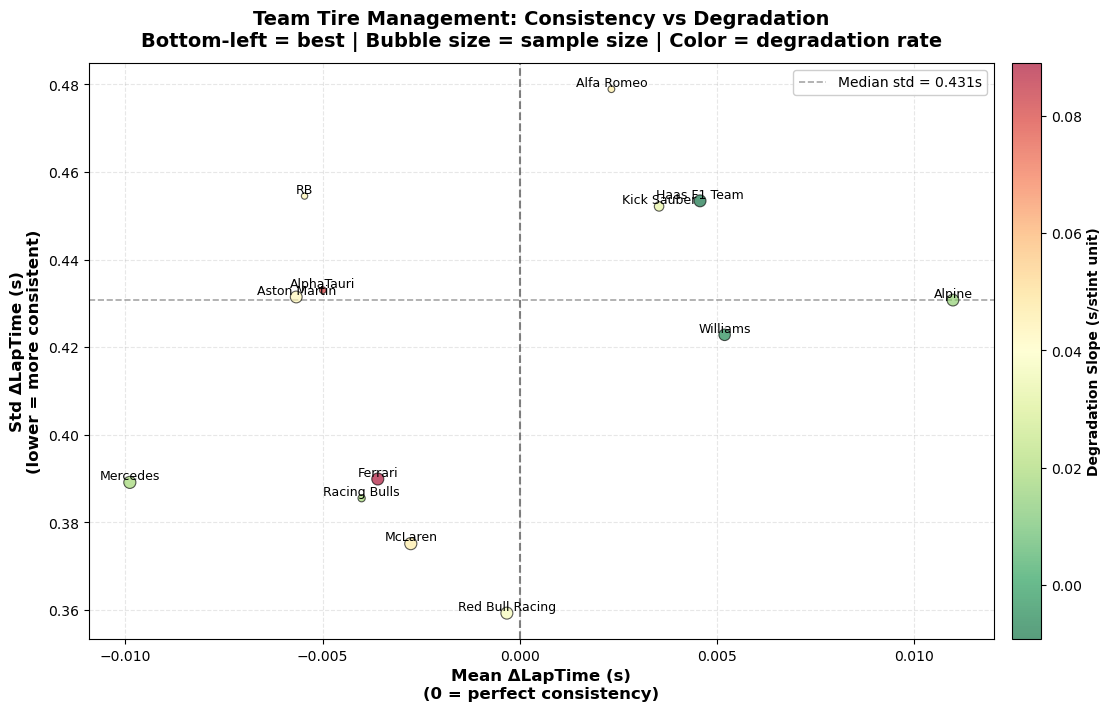


Team tire management rankings

Rank  Team                 Std Δ      Mean Δ     Slope        n         
1     Red Bull Racing      0.3593s   -0.0003s   +0.03731      3,714
2     McLaren              0.3752s   -0.0028s   +0.04571      3,804
3     Racing Bulls         0.3855s   -0.0040s   +0.01834      1,360
4     Mercedes             0.3891s   -0.0099s   +0.01835      3,794
5     Ferrari              0.3899s   -0.0036s   +0.08902      3,737
6     Williams             0.4228s   +0.0052s   -0.00373      3,396
7     Alpine               0.4308s   +0.0110s   +0.01575      3,570
8     Aston Martin         0.4315s   -0.0057s   +0.04252      3,591
9     AlphaTauri           0.4330s   -0.0050s   +0.08120      1,157
10    Kick Sauber          0.4521s   +0.0035s   +0.03301      2,328


In [14]:

def compute_team_stats(df):
    """Compute tire management metrics per team."""
    d = df.dropna(subset=["delta_laptime", "Team", "rel_stint_progress"]).copy()
    
    # Mid-stint only (10-90%) to avoid pit/outlap effects
    mid = d[(d["rel_stint_progress"] >= 0.1) & (d["rel_stint_progress"] <= 0.9)].copy()
    
    results = []
    for team, g in mid.groupby("Team"):
        if len(g) < 100:
            continue
        
        mean_delta = g["delta_laptime"].mean()
        std_delta = g["delta_laptime"].std()
        
        # Degradation slope (how fast they degrade over stint)
        if len(g) > 10:
            slope, _, _, _, _ = linregress(g["rel_stint_progress"], g["delta_laptime"])
        else:
            slope = np.nan
        
        results.append({
            "Team": team,
            "mean_delta": mean_delta,
            "std_delta": std_delta,
            "degradation_slope": slope,
            "n_laps": len(g)
        })
    
    return pd.DataFrame(results)


def plot_team_consistency(stats):
    """
    All-in-one plot: Consistency vs Degradation
    
    Bottom-left = best teams (low variance, flat degradation)
    """
    fig, ax = plt.subplots(figsize=(11, 7), constrained_layout=True)
    
    # Scatter with degradation slope as color
    scatter = ax.scatter(stats["mean_delta"], stats["std_delta"], 
                        s=stats["n_laps"]/50, alpha=0.65, 
                        c=stats["degradation_slope"], cmap='RdYlGn_r',
                        edgecolors='black', linewidth=0.8, zorder=3)
    
    # Team labels
    for _, row in stats.iterrows():
        ax.text(row["mean_delta"], row["std_delta"], row["Team"], 
               fontsize=9, ha='center', va='bottom', fontweight='normal')
    
    # Reference lines
    median_std = stats["std_delta"].median()
    ax.axhline(median_std, ls='--', c='0.5', lw=1.2, alpha=0.7, zorder=2,
              label=f"Median std = {median_std:.3f}s")
    ax.axvline(0, ls='--', c='0.3', lw=1.5, alpha=0.7, zorder=2)
    
    # Colorbar
    cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
    cbar.set_label("Degradation Slope (s/stint unit)", fontsize=10, fontweight='bold')
    
    # Labels
    ax.set_xlabel("Mean ΔLapTime (s)\n(0 = perfect consistency)", 
                  fontsize=12, fontweight='bold')
    ax.set_ylabel("Std ΔLapTime (s)\n(lower = more consistent)", 
                  fontsize=12, fontweight='bold')
    ax.set_title("Team Tire Management: Consistency vs Degradation\n" +
                 "Bottom-left = best | Bubble size = sample size | Color = degradation rate",
                 fontsize=14, fontweight='bold', pad=12)
    ax.legend(fontsize=10, framealpha=0.95, loc='upper right')
    ax.grid(alpha=0.3, ls="--", zorder=1)
    
    plt.savefig('figures/team_tire_management.pdf', dpi=300, bbox_inches='tight')
    plt.show()


def print_rankings(stats):
    """Print top 5 teams by consistency."""
  
    print(f"\nTeam tire management rankings")
    print("="*70)
    print(f"\n{'Rank':<5} {'Team':<20} {'Std Δ':<10} {'Mean Δ':<10} {'Slope':<12} {'n':<10}")

    
    for i, (_, row) in enumerate(stats.sort_values("std_delta").head(10).iterrows(), 1):
        print(f"{i:<5} {row['Team']:<20} {row['std_delta']:.4f}s   "
              f"{row['mean_delta']:+.4f}s   {row['degradation_slope']:+.5f}   "
              f"{int(row['n_laps']):>8,}")
    

stats = compute_team_stats(df_pairs)
    
# Single comprehensive plot
plot_team_consistency(stats)
    
# Rankings table
print_rankings(stats)


In [15]:
# This function implements a minimal, causal 'pushing' detector with robust scale and optional momentum/traffic tweaks to seem how well we can identify 'pushing' laps.

def compute_pushing_flags_simple_improved(
    df,
    window=5,                 # past laps for baseline
    k=0.7,                    # threshold multiplier (in MAD units)
    momentum_window=3,        # past laps for momentum confirmation
    momentum_threshold=0.3,   # fraction of MAD required for momentum
    use_momentum=True,
    use_traffic_adjustment=False,
    use_race_normalization=True
):
    """
    Minimal, causal 'pushing' detector with robust scale and optional momentum/traffic tweaks.
    Uses ONLY information available up to lap t (no leakage).
    Returns df with: pushing (0/1), pushing_confidence, plus helper columns.
    """
    df = df.copy().sort_values(['year','round','RacingNumber','Stint','lap_number'])
    g  = df.groupby(['year','round','RacingNumber','Stint'], group_keys=False)

    # 0) Pace (optionally normalized by race baseline for circuit-independence)
    if use_race_normalization and 'race_baseline' in df.columns:
        df['pace_norm'] = df['LapTime'] / df['race_baseline']
        pace_col = 'pace_norm'
    else:
        pace_col = 'LapTime'

    # 1) Stint-local baseline (past-only rolling median, strictly causal)
    df['stint_baseline'] = g[pace_col].apply(lambda x: (x.shift(1)).rolling(window, min_periods=2).median())

    # 2) Deviation from baseline (negative => faster than expected)
    df['dev_stint'] = df[pace_col] - df['stint_baseline']

    # 3) True past-only MAD: median( |past - past_rolling_median| )
    #    More mathematically correct than MAD of deviations
    df['mad_raw'] = (df[pace_col].shift(1) - df['stint_baseline'].shift(1)).abs()
    df['stint_mad'] = g['mad_raw'].apply(lambda x: x.rolling(window, min_periods=3).median())

    # Fallback scale for early laps (tiny positive value)
    global_scale = (df[pace_col].median() if np.isfinite(df[pace_col].median()) else 1.0) * 1e-3
    df['stint_mad'] = df['stint_mad'].replace(0, np.nan).fillna(global_scale)

    # 4) Optional momentum confirmation (past-only, causal)
    if use_momentum:
        df['momentum'] = g['dev_stint'].apply(lambda x: x.shift(1).rolling(momentum_window, min_periods=1).mean())
        df['momentum_valid'] = (df['momentum'] <= -(momentum_threshold * df['stint_mad'])).astype(int)
    else:
        df['momentum'] = np.nan
        df['momentum_valid'] = 1

    # 5) Optional light traffic adjustment of the threshold (kept OFF by default)
    if use_traffic_adjustment:
        k_adj = pd.Series(k, index=df.index)
        if 'in_dirty_air' in df.columns:
            k_adj = np.where(df['in_dirty_air'] == 1, k * 1.15, k_adj)
        if 'in_clean_air' in df.columns:
            k_adj = np.where(df['in_clean_air'] == 1, k * 0.85, k_adj)
        if 'in_drs_range' in df.columns:
            k_adj = np.where(df['in_drs_range'] == 1, k * 0.75, k_adj)
        k_adj = pd.Series(k_adj, index=df.index)
    else:
        k_adj = pd.Series(k, index=df.index)

    # 6) Main flag + confidence (all causal, no look-ahead)
    threshold = -k_adj * df['stint_mad']
    df['pushing'] = ((df['dev_stint'] <= threshold) & (df['momentum_valid'] == 1)).astype(int)

    # Return only pushing column (will be added back to df_pairs via assignment)
    return df[['pushing']].copy()


# Apply pushing detection (optimized version)
df_pairs['pushing'] = compute_pushing_flags_simple_improved(
    df_pairs,
    window=5,
    k=0.8,
    momentum_window=3,
    momentum_threshold=0.3,
    use_momentum=True,
    use_traffic_adjustment=False,
    use_race_normalization=True
)['pushing'].values


# Count pushing laps
n_pushing = (df_pairs['pushing'] == 1).sum()
total_laps = len(df_pairs)
pct_pushing = 100 * n_pushing / total_laps
print(f"Pushing laps: {n_pushing:,} / {total_laps:,} ({pct_pushing:.1f}%)")


Pushing laps: 5,764 / 40,426 (14.3%)


<h1><center> Merging the two main dataset </center></h1>

In [16]:

print(f"\nMerging the filtered dataset 03 with circuit geometry")

# Drop year and round from circuit_geometry to avoid duplicates (we only need the geometry, not the specific year/round)
circuit_geo_to_merge = circuit_geometry.drop(columns=['year', 'round'])

# Merge on circuit name
df_merged = df_pairs.merge(
    circuit_geo_to_merge, 
    on='name', 
    how='left',
    suffixes=('', '_circuit')
)

columns_to_drop = [ 'circuit_ref']

# Add squared term (captures accelerating degradation)

df_merged['LapInStint_squared'] = df_merged['LapInStint'] ** 2



Merging the filtered dataset 03 with circuit geometry


<h1><center> Correlation matrix </center></h1>


 Plotting the correlation matrix for numerical features

Numerical columns for correlation (52):
['year', 'round', 'RacingNumber', 'lap_number', 'LapTime', 'Position', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed', 'Stint', 'TyreAgeAtStart', 'LapInStint', 'is_leader', 'in_drs_range', 'in_dirty_air', 'in_clean_air', 'stint_length', 'rel_stint_progress', 'LapTime_next', 'delta_laptime', 'LapTime_next_normalized', 'race_median', 'laptime_rolling_std_3', 'laptime_change_prev', 'laptime_cumulative_trend', 'stint_mean_so_far', 'pushing', 'num_drs_zones', 'length_km', 'num_turns', 'slow_corners', 'medium_corners', 'fast_corners', 'flat_corners', 'slow_cluster_max', 'straight_distance_m', 'straight_ratio', 'straight_len_max_m', 'n_major_straights', 'heavy_braking_zones', 'heavy_braking_mean_dv_kmh', 'hb_spacing_std_m', 'corner_density_tpkm', 'avg_corner_angle', 'total_corner_angle', 'avg_corner_distance', 'drs_zones_detected', 'drs_total_len_m', 'LapInStint_squa

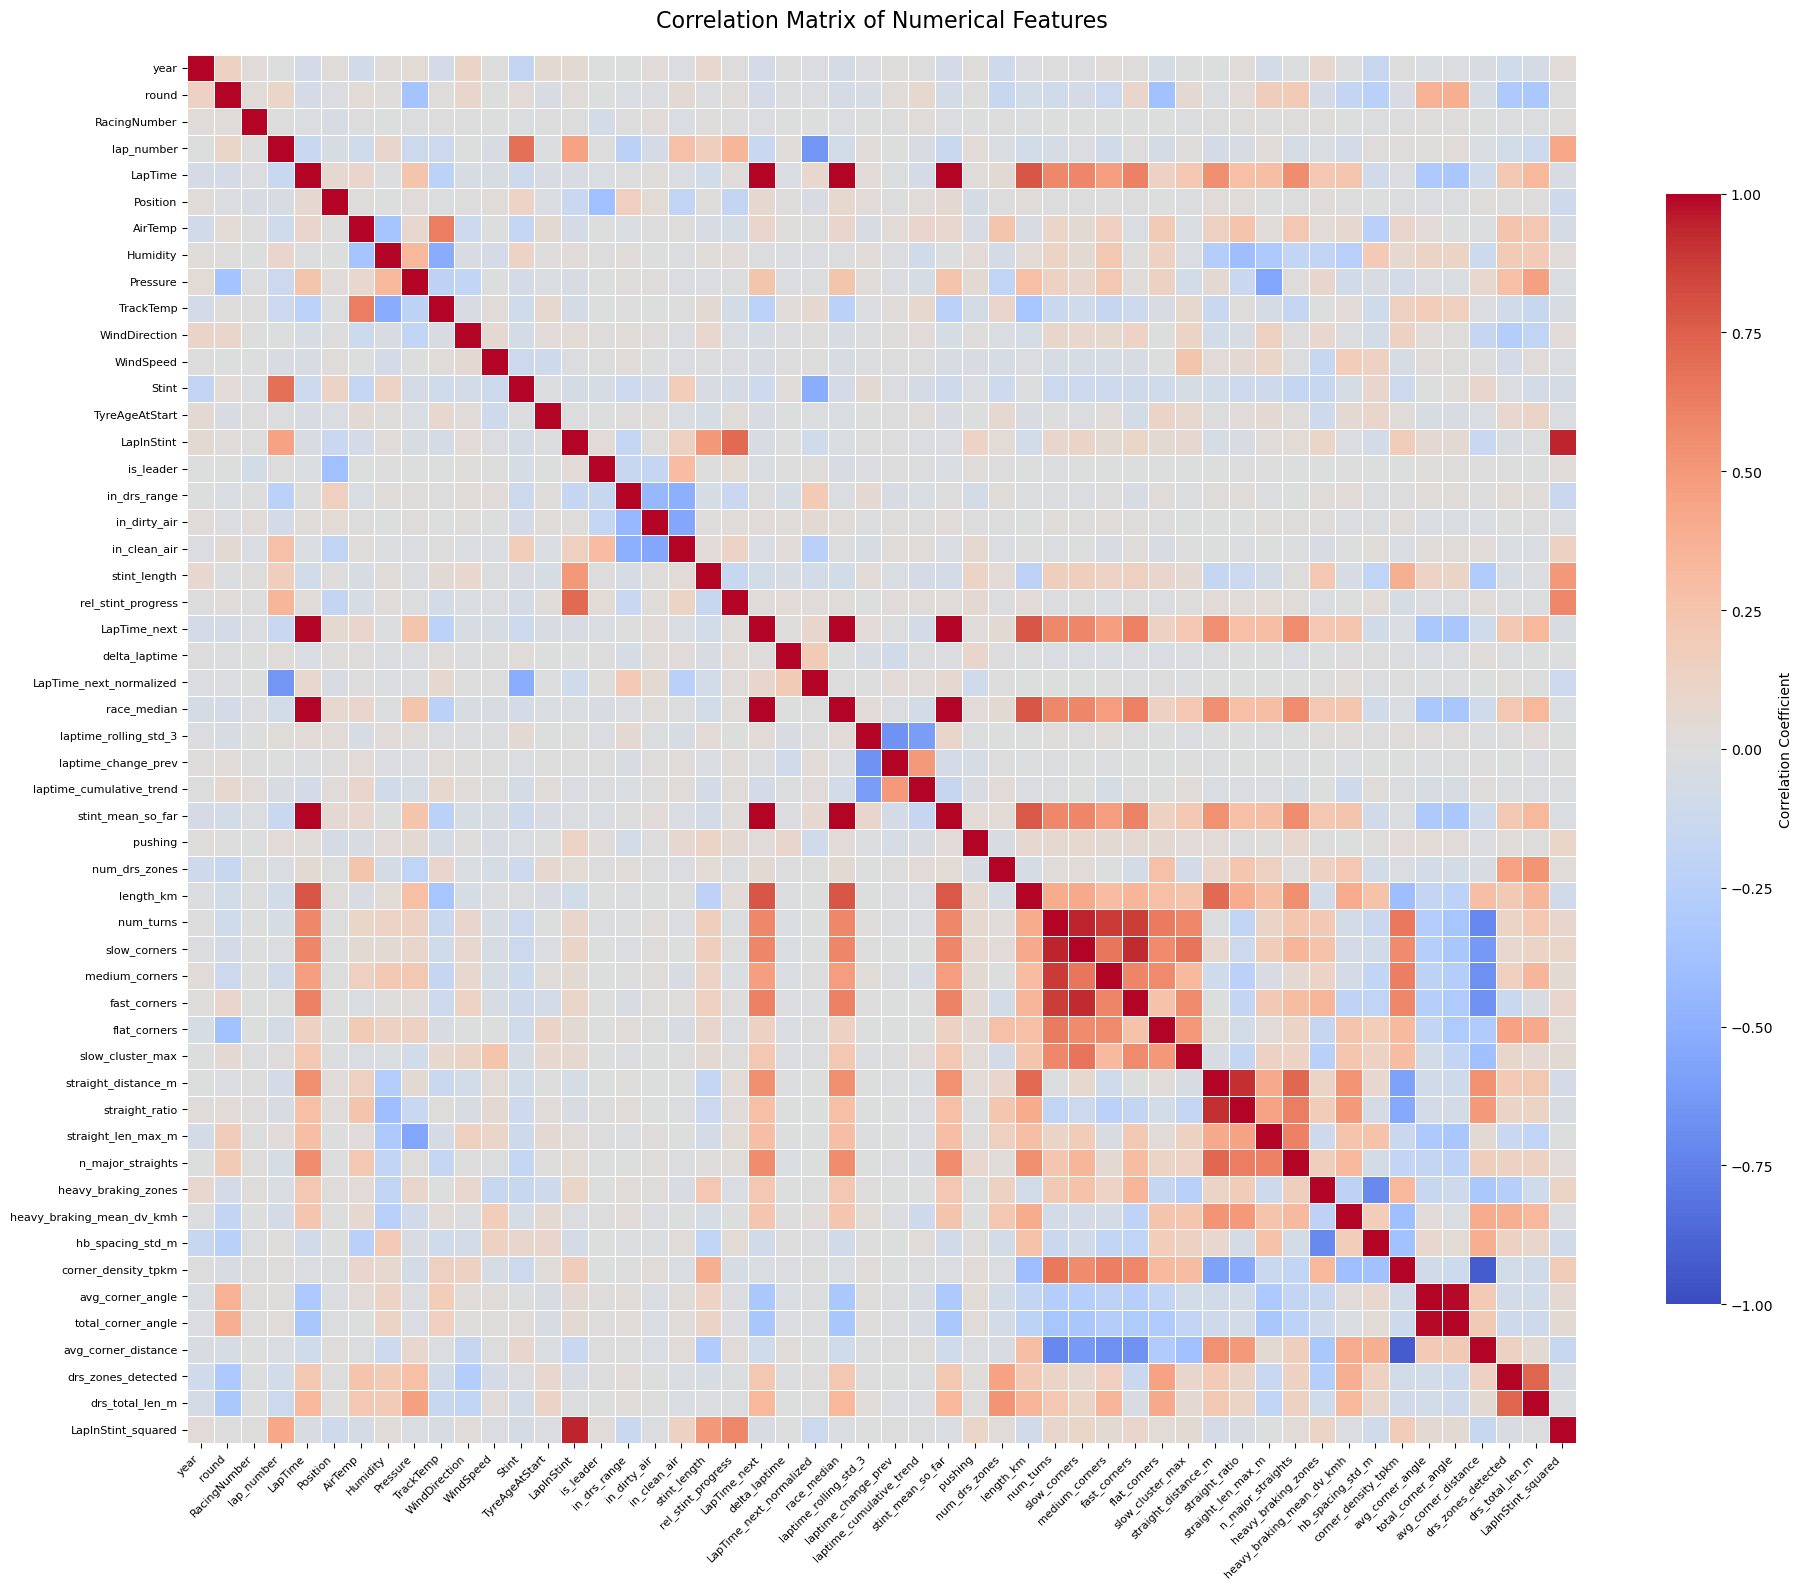

In [17]:

print(f"\n Plotting the correlation matrix for numerical features")

# Select only numerical columns for correlation
numerical_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumerical columns for correlation ({len(numerical_cols)}):")
print(numerical_cols)

# Calculate correlation matrix
df_corr = df_merged[numerical_cols].corr()

# Create figure with appropriate size
fig, ax = plt.subplots(figsize=(20, 16))

# Create heatmap
sns.heatmap(df_corr, 
            annot=False,  # Set to True if you want to see correlation values
            cmap='coolwarm',
            center=0,
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.5,  
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
            ax=ax)

plt.title('Correlation Matrix of Numerical Features', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()

# # Save the plot
plt.savefig('figures/Correlation_Matrix.pdf', dpi=300, bbox_inches='tight')

# plt.show()

# Print some high correlations (absolute value > 0.7, excluding diagonal)
print(f"\n High Correlations (|r| > 0.7)")


# Get upper triangle of correlation matrix
mask = np.triu(np.ones_like(df_corr, dtype=bool))
df_corr_upper = df_corr.where(~mask)

# Find high correlations
high_corr = []
for col in df_corr_upper.columns:
    for idx in df_corr_upper.index:
        val = df_corr_upper.loc[idx, col]
        if pd.notna(val) and abs(val) > 0.7:
            high_corr.append((idx, col, val))

# Sort by absolute correlation value
high_corr.sort(key=lambda x: abs(x[2]), reverse=True)

if high_corr:
    print(f"\nFound {len(high_corr)} high correlations:")
    for var1, var2, corr_val in high_corr[:20]:  # Show top 20
        print(f"  {var1:30s} <-> {var2:30s} : {corr_val:+.3f}")
    if len(high_corr) > 20:
        print(f"  ... and {len(high_corr) - 20} more")
else:
    print("\nNo correlations with |r| > 0.7 found (excluding diagonal)")

In [18]:
 # dropping columns with correlation almost 1 in order to avoid multicollinearity issues
print(f"\nConverting corner counts to shares")

# Convert corner counts to shares (proportions)
df_merged['slow_share'] = df_merged['slow_corners'] / df_merged['num_turns']
df_merged['medium_share'] = df_merged['medium_corners'] / df_merged['num_turns']
df_merged['fast_share'] = df_merged['fast_corners'] / df_merged['num_turns']
df_merged['flat_share'] = df_merged['flat_corners'] / df_merged['num_turns']

# Handle any potential division by zero (if num_turns = 0)
df_merged['slow_share'].fillna(0, inplace=True)
df_merged['medium_share'].fillna(0, inplace=True)
df_merged['fast_share'].fillna(0, inplace=True)
df_merged['flat_share'].fillna(0, inplace=True)

# WIND ENCODING

# Convert degrees to radians
theta = np.deg2rad(df_merged['WindDirection'])

# Cyclic encoding (prevents discontinuity)
df_merged['wind_sin'] = np.sin(theta)
df_merged['wind_cos'] = np.cos(theta)

# Columns to drop due to high correlation or redundancy

columns_to_drop_corr = [
    # REMOVE LEAKY TEMPORAL (highly correlated with target)
    'laptime_rolling_mean_3',      # r=0.997 with target
    'laptime_min_so_far',          # r=0.995 with target
    'stint_baseline',              # r=0.992 with target
    'pace_momentum',               # redundant with laptime_change_prev
    
    # REMOVE HIGH CORRELATION PAIRS (keep one from each)
    'total_corner_angle',          # keep avg_corner_angle (r=0.985)
    'corner_density_tpkm',         # keep avg_corner_distance (r=-0.926)
    'drs_zones_detected',          # keep num_drs_zones
    'hb_spacing_std_m',            # keep heavy_braking_zones
    'straight_distance_m',         # keep straight metrics
    
    # REMOVE RAW COUNTS (keep shares instead)
    'slow_corners',
    'medium_corners',
    'fast_corners',
    'flat_corners',
    
    # REMOVE REDUNDANT/OLD
    'rel_stint_progress',
    'flat_share',                  # drop the one with lowest st.dev to avoid dummy variable
    'WindDirection',               # keep wind_sin, wind_cos instead
    'gap_is_imputed',
    'delta_laptime',
    'delta_laptime_pct',           # OLD TARGET
    'delta_laptime_norm',
    'stint_length',
    #'LapTime_next',                # raw reference (keep race_median instead)
    'LapTime', 
    'race_median',
    'IntervalToPositionAhead',
    #'delta_laptime'
    'stint_mean_so_far'              # high correlation with target
]

# Drop columns that exist in the dataframe
existing_cols_to_drop = [col for col in columns_to_drop_corr if col in df_merged.columns]
print(f"\nDropping {len(existing_cols_to_drop)} columns:")
for col in existing_cols_to_drop:
    print(f"  - {col}")

df_merged.drop(columns=existing_cols_to_drop, inplace=True)

# converting the length_km to meters
df_merged['length_km'] = df_merged['length_km'] * 1000  # Convert km to meters



column_order = [ 
    # METADATA
    'year', 'round', 'name', 'Grand_Prix', 'type', 'Name', 'RacingNumber', 'Team', 'lap_number',

    # LAGGED TARGETS 
    #'LapTime_prev',          
    #LapTime_prev_prev', 
         
    
    # RACE STATE
    'Position', 'LapTime','is_leader', 'in_drs_range', 'in_clean_air', 
    'in_traffic', 'in_dirty_air', 'pushing',
    
    # TYRE/STINT
    'Stint', 'Compound', 'TyreAgeAtStart', 'LapInStint', 'LapInStint_squared',
    
    # TARGET (MAIN)
    'LapTime_next',
    #'delta_laptime',          # main target
    
    # REFERENCE (for denormalization)
    #'race_median',
    
    # TEMPORAL FEATURES (clean, low correlation with target)
    'laptime_rolling_std_3',       # consistency metric
    'laptime_cumulative_trend',    # degradation rate
    'laptime_change_prev',        # momentum (lap-to-lap change)
    'stint_mean_so_far',        # stint-relative pace
 
    
    # CIRCUIT GEOMETRY
    'num_drs_zones', 'length_km', 'num_turns', 'slow_share', 'medium_share', 'fast_share',
    'slow_cluster_max', 'straight_ratio', 'straight_len_max_m', 'n_major_straights',
    'heavy_braking_zones', 'heavy_braking_mean_dv_kmh', 'hb_at_end_of_max', 
    'avg_corner_angle', 'avg_corner_distance', 'drs_total_len_m',
    
    # ENVIRONMENT
    'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindSpeed', 'wind_sin', 'wind_cos'
]

df_merged = df_merged[[col for col in column_order if col in df_merged.columns]]

print(f"\nMerged dataset shape: {df_merged.shape}")
print(f"Columns after merge: {len(df_merged.columns)}")

# Save the merged dataset
df_merged.to_excel('csv_output/Filtered_04_with_circuit_geometry.xlsx', index=False)
print(f"\n✓ Saved: csv_output/Filtered_04_with_circuit_geometry.xlsx")

print(f"\nFinal merged columns ({len(df_merged.columns)}):")
print(df_merged.columns.tolist())


Converting corner counts to shares

Dropping 18 columns:
  - total_corner_angle
  - corner_density_tpkm
  - drs_zones_detected
  - hb_spacing_std_m
  - straight_distance_m
  - slow_corners
  - medium_corners
  - fast_corners
  - flat_corners
  - rel_stint_progress
  - flat_share
  - WindDirection
  - delta_laptime
  - stint_length
  - LapTime
  - race_median
  - IntervalToPositionAhead
  - stint_mean_so_far

Merged dataset shape: (40426, 47)
Columns after merge: 47

✓ Saved: csv_output/Filtered_04_with_circuit_geometry.xlsx

Final merged columns (47):
['year', 'round', 'name', 'Grand_Prix', 'type', 'Name', 'RacingNumber', 'Team', 'lap_number', 'Position', 'is_leader', 'in_drs_range', 'in_clean_air', 'in_dirty_air', 'pushing', 'Stint', 'Compound', 'TyreAgeAtStart', 'LapInStint', 'LapInStint_squared', 'LapTime_next', 'laptime_rolling_std_3', 'laptime_cumulative_trend', 'laptime_change_prev', 'num_drs_zones', 'length_km', 'num_turns', 'slow_share', 'medium_share', 'fast_share', 'slow_clu


Final Correlation Matrix

Numerical columns for correlation (40):
['year', 'round', 'RacingNumber', 'lap_number', 'Position', 'is_leader', 'in_drs_range', 'in_clean_air', 'in_dirty_air', 'pushing', 'Stint', 'TyreAgeAtStart', 'LapInStint', 'LapInStint_squared', 'LapTime_next', 'laptime_rolling_std_3', 'laptime_cumulative_trend', 'laptime_change_prev', 'num_drs_zones', 'length_km', 'num_turns', 'slow_share', 'medium_share', 'fast_share', 'slow_cluster_max', 'straight_ratio', 'straight_len_max_m', 'n_major_straights', 'heavy_braking_zones', 'heavy_braking_mean_dv_kmh', 'avg_corner_angle', 'avg_corner_distance', 'drs_total_len_m', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindSpeed', 'wind_sin', 'wind_cos']


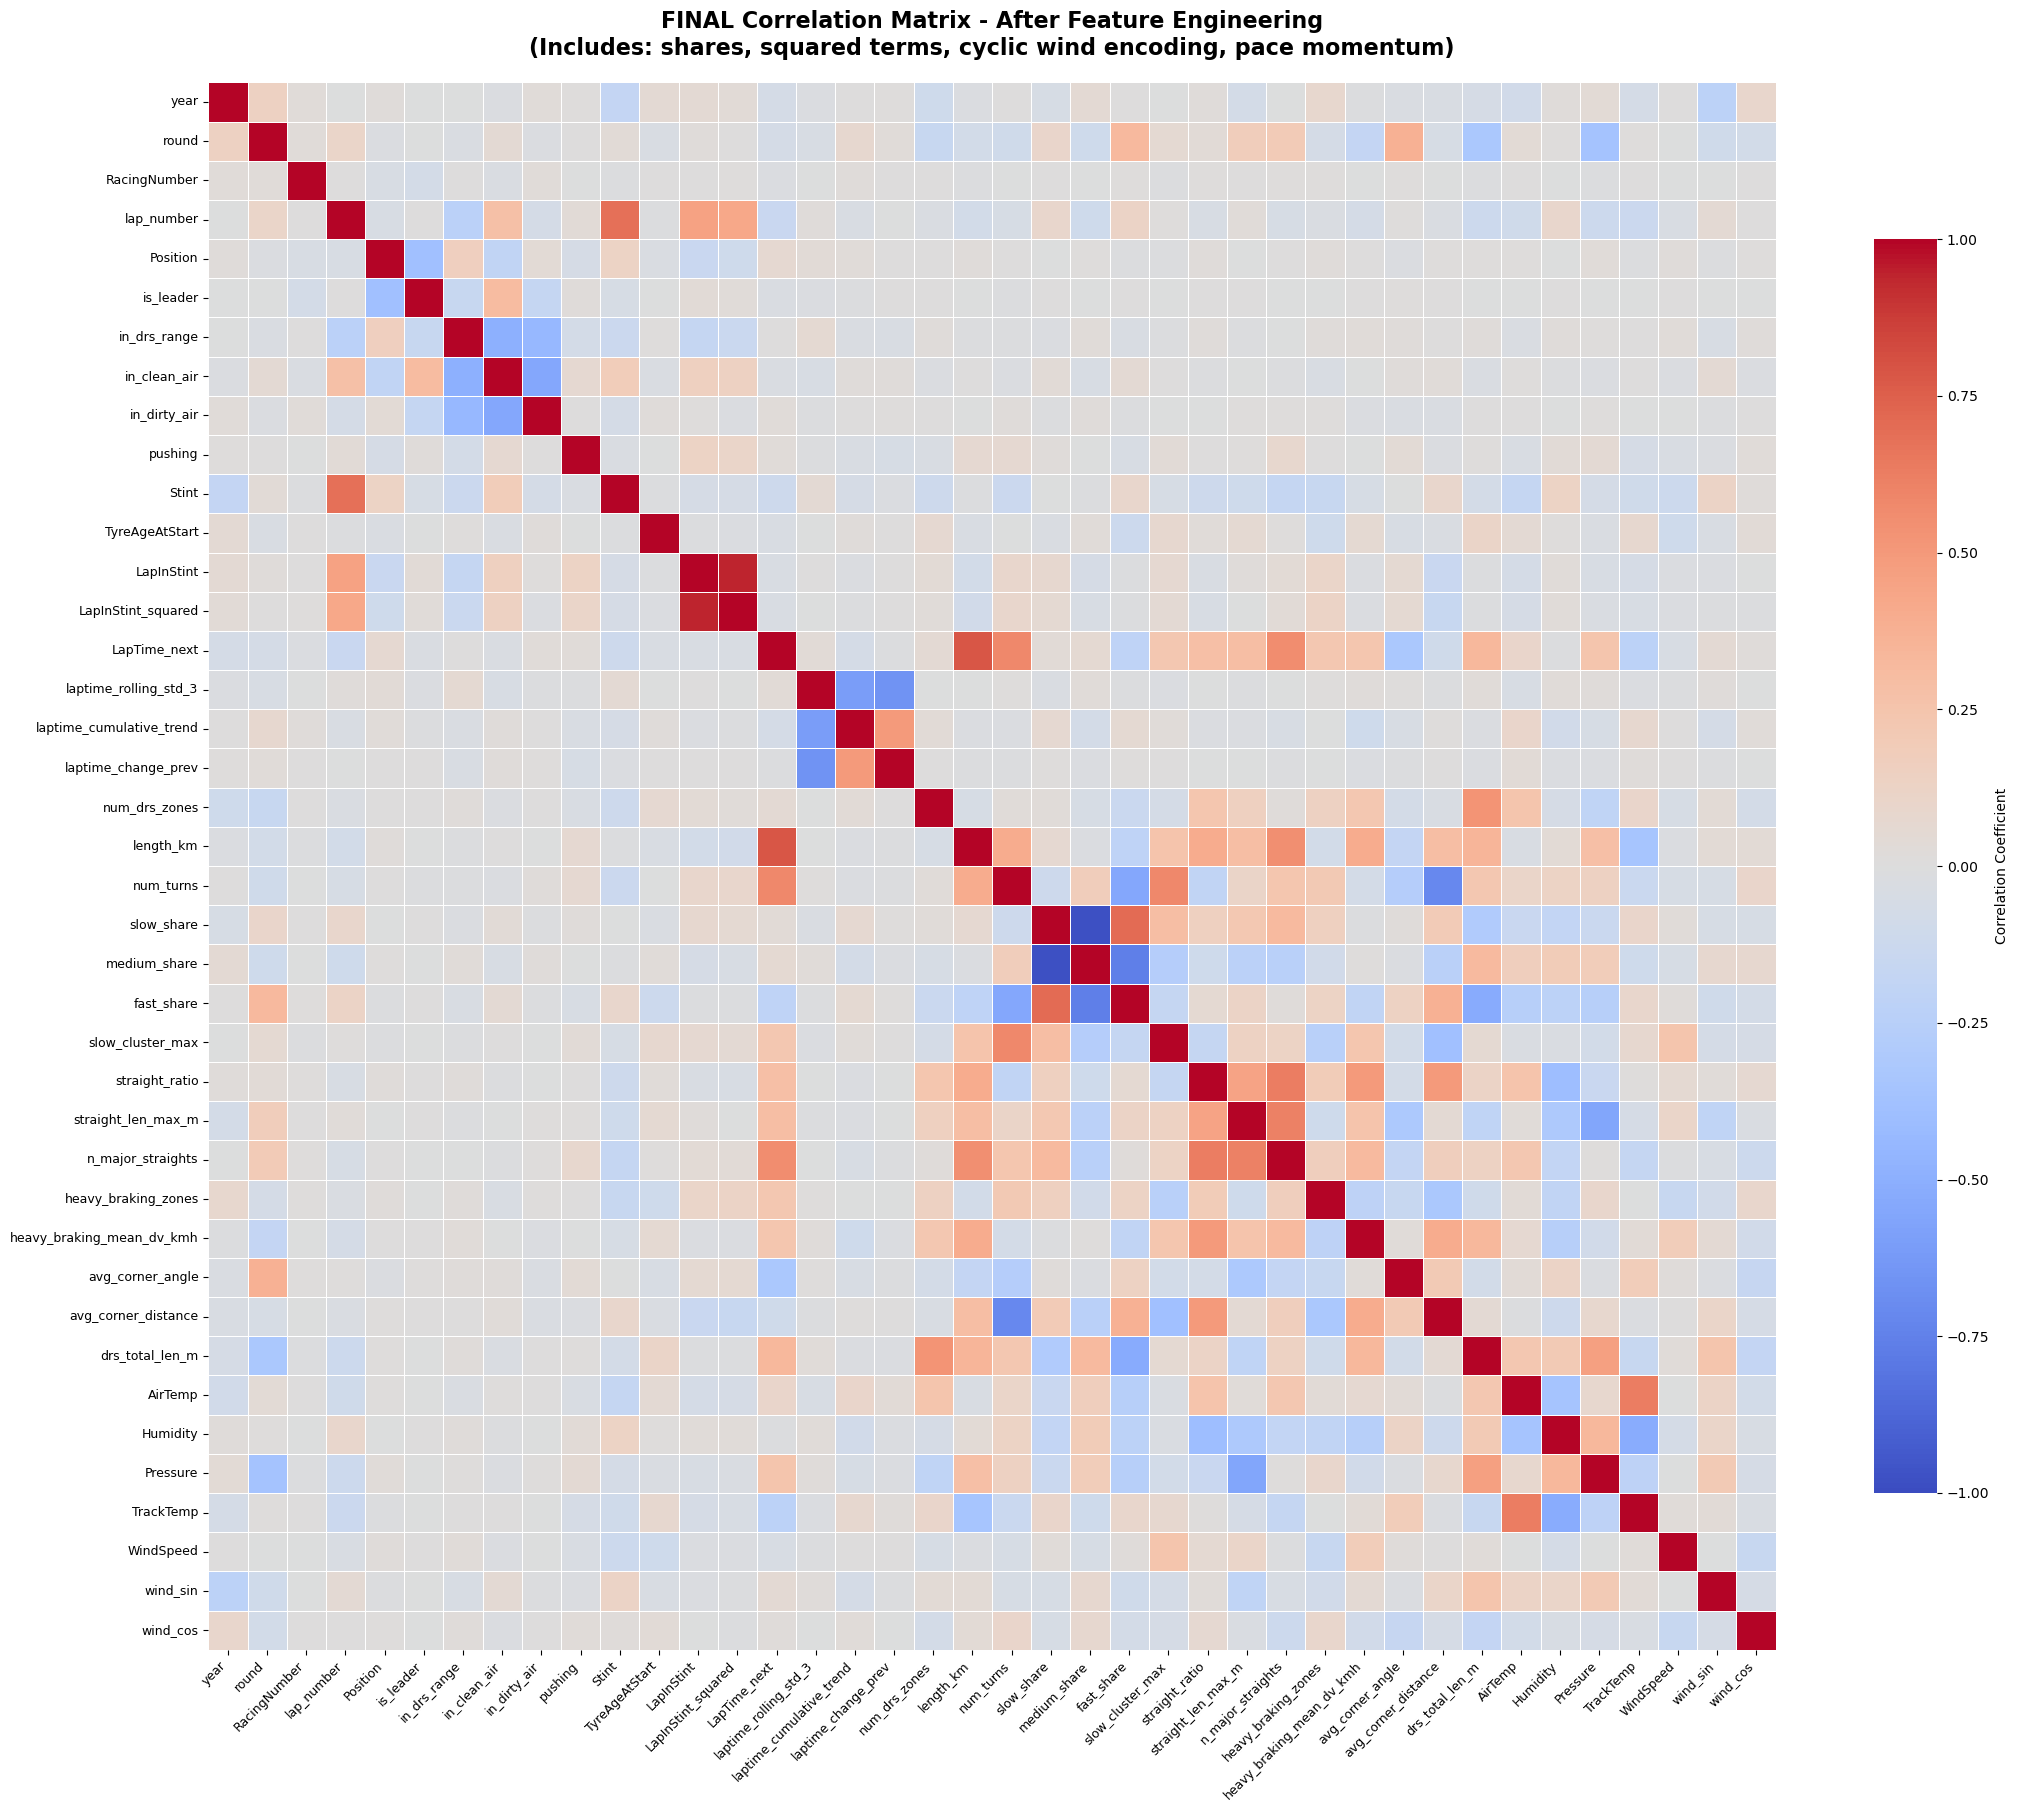

In [19]:

# ──────────────────────────────────────────────────────────────────────────
# FINAL CORRELATION MATRIX - After all feature engineering
# ──────────────────────────────────────────────────────────────────────────
print(f"\n{'='*90}")
print("Final Correlation Matrix")
print(f"{'='*90}")

# Select only numerical columns for correlation
numerical_cols_final = df_merged.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumerical columns for correlation ({len(numerical_cols_final)}):")
print(numerical_cols_final)

# Calculate correlation matrix
df_corr_final = df_merged[numerical_cols_final].corr()

# Create figure with appropriate size
fig, ax = plt.subplots(figsize=(22, 18))

# Create heatmap
sns.heatmap(df_corr_final, 
            annot=False,  # Set to True if you want to see correlation values
            cmap='coolwarm',
            center=0,
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.5,  
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
            ax=ax)

plt.title('FINAL Correlation Matrix - After Feature Engineering\n(Includes: shares, squared terms, cyclic wind encoding, pace momentum)', 
          fontsize=16, pad=20, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()

# Save the plot
plt.savefig('figures/Correlation_Matrix_Final.pdf', dpi=300, bbox_inches='tight')
plt.show()


# Get upper triangle of correlation matrix
mask = np.triu(np.ones_like(df_corr_final, dtype=bool))
df_corr_upper_final = df_corr_final.where(~mask)

# Find high correlations
high_corr_final = []
for col in df_corr_upper_final.columns:
    for idx in df_corr_upper_final.index:
        val = df_corr_upper_final.loc[idx, col]
        if pd.notna(val) and abs(val) > 0.7:
            high_corr_final.append((idx, col, val))

# Sort by absolute correlation value
high_corr_final.sort(key=lambda x: abs(x[2]), reverse=True)



In [20]:
import pickle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupShuffleSplit


<h1><center> Splitting the dataset  </center></h1>

In [21]:

print("Splitting dataset into Train/Validation/Test sets (70%/15%/15%) - keeping races together")

# Create a unique race identifier (group key to keep races together)
df_merged['race_id'] = df_merged['year'].astype(str) + '_' + df_merged['round'].astype(str) + '_' + df_merged['name']

# Get unique races
unique_races = df_merged['race_id'].unique()
n_races = len(unique_races)
print(f"\nTotal unique races: {n_races}")

# Split into train (70%) and temp (30%) - keeping races together
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, temp_idx = next(gss1.split(df_merged, groups=df_merged['race_id']))

df_train = df_merged.iloc[train_idx].copy()
df_temp = df_merged.iloc[temp_idx].copy()

# Split temp into validation (50%) and test (50%) - this gives 15% and 15% of total
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
val_idx, test_idx = next(gss2.split(df_temp, groups=df_temp['race_id']))

df_val = df_temp.iloc[val_idx].copy()
df_test = df_temp.iloc[test_idx].copy()

# Count races in each split
train_races = df_train['race_id'].nunique()
val_races = df_val['race_id'].nunique()
test_races = df_test['race_id'].nunique()

print(f"\nRace split:")
print(f"  Train: {train_races} races ({train_races/n_races*100:.1f}%)")
print(f"  Validation: {val_races} races ({val_races/n_races*100:.1f}%)")
print(f"  Test: {test_races} races ({test_races/n_races*100:.1f}%)")

# Drop the race_id helper column
df_train.drop(columns=['race_id'], inplace=True)
df_val.drop(columns=['race_id'], inplace=True)
df_test.drop(columns=['race_id'], inplace=True)

print(f"\nDataset sizes (laps):")
print(f"  Train: {len(df_train)} laps ({len(df_train)/len(df_merged)*100:.1f}%)")
print(f"  Validation: {len(df_val)} laps ({len(df_val)/len(df_merged)*100:.1f}%)")
print(f"  Test: {len(df_test)} laps ({len(df_test)/len(df_merged)*100:.1f}%)")

# Save the splits
df_train.to_excel('csv_output/Train_set.xlsx', index=False)
df_val.to_excel('csv_output/Validation_set.xlsx', index=False)
df_test.to_excel('csv_output/Test_set.xlsx', index=False)


Splitting dataset into Train/Validation/Test sets (70%/15%/15%) - keeping races together

Total unique races: 65

Race split:
  Train: 45 races (69.2%)
  Validation: 10 races (15.4%)
  Test: 10 races (15.4%)

Dataset sizes (laps):
  Train: 28244 laps (69.9%)
  Validation: 5035 laps (12.5%)
  Test: 7147 laps (17.7%)


In [22]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ──────────────────────────────────────────────────────────────────────────
# Create synthetic tyre feature (before PCA)
# ──────────────────────────────────────────────────────────────────────────
print(f"\nCreating synthetic features...")
for df_split in [df_train, df_val, df_test]:
    df_split['is_new_tyre'] = (df_split['TyreAgeAtStart'] == 0).astype(int)
print(f"   is_new_tyre created (1=fresh, 0=used)")


# ══════════════════════════════════════════════════════════════════════════
# PCA ON GEOMETRY FEATURES
# ══════════════════════════════════════════════════════════════════════════


print(f"\nApplying PCA to Geometry Features")


# Define geometry columns (all available in circuit_geometry dataset)
geom_cols_all = [
    'num_drs_zones', 'length_km', 'num_turns',
    'slow_share', 'medium_share', 'fast_share', 'slow_cluster_max',
    'straight_ratio', 'straight_len_max_m', 'n_major_straights',
    'heavy_braking_zones', 'heavy_braking_mean_dv_kmh', 'hb_at_end_of_max',
    'avg_corner_angle', 'avg_corner_distance', 'drs_total_len_m'
]

# Filter to only columns that exist in the dataset
geom_cols = [col for col in geom_cols_all if col in df_train.columns]
print(f"\nGeometry columns available: {len(geom_cols)}/{len(geom_cols_all)}")
print(f"  Available: {geom_cols}")
missing_cols = [col for col in geom_cols_all if col not in df_train.columns]
if missing_cols:
    print(f"  Missing: {missing_cols}")

def fit_geom_pca(train_df, val_df, test_df, geom_cols, var_cut=0.90, k_bounds=(3, 6)):
    """
    Fit PCA on geometry features using ONLY train circuits.
    
    Parameters:
    -----------
    train_df : DataFrame
        Training data
    val_df : DataFrame
        Validation data
    test_df : DataFrame
        Test data
    geom_cols : list
        List of geometry column names
    var_cut : float
        Cumulative variance threshold for selecting number of components
    k_bounds : tuple
        (min, max) bounds for number of components
    
    Returns:
    --------
    train_df, val_df, test_df : DataFrames with added PC columns
    pc_cols : list of PC column names
    """
    circuit_key = ['year', 'name']
    
    # Combine all data to get geometry features (same circuit = same geometry)
    all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
    
    # Extract unique circuit geometry (one row per circuit)
    geom_all = (
        all_df[circuit_key + geom_cols]
        .drop_duplicates(subset=circuit_key)
        .dropna(subset=geom_cols)
    )
    
    if geom_all.empty:
        raise ValueError("No geometry features found in data")
    
    # Get train circuits only
    train_circuits = train_df[circuit_key].drop_duplicates()
    geom_train = train_circuits.merge(geom_all, on=circuit_key, how='left')
    
    if geom_train[geom_cols].isna().any().any():
        print("WARNING: Some train circuits have missing geometry features")
        geom_train = geom_train.dropna(subset=geom_cols)
    
    # Fit scaler and PCA on TRAIN circuits only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(geom_train[geom_cols])
    
    pca = PCA().fit(X_train_scaled)
    cumvar = pca.explained_variance_ratio_.cumsum()
    
    # Select number of components based on variance threshold
    k = int((cumvar >= var_cut).argmax() + 1)
    k = min(max(k, k_bounds[0]), k_bounds[1])
    
    # Transform ALL circuits (using scaler and PCA fitted on train)
    X_all_scaled = scaler.transform(geom_all[geom_cols])
    PCs = pca.transform(X_all_scaled)[:, :k]
    
    # Create DataFrame with PCs
    pcs_df = geom_all[circuit_key].copy()
    pc_cols = []
    for i in range(k):
        col_name = f'geom_PC{i+1}'
        pcs_df[col_name] = PCs[:, i]
        pc_cols.append(col_name)
    
    # Merge PCs back to original splits
    train_df = train_df.merge(pcs_df, on=circuit_key, how='left')
    val_df = val_df.merge(pcs_df, on=circuit_key, how='left')
    test_df = test_df.merge(pcs_df, on=circuit_key, how='left')
    
    # Verify no data leakage (PCs should be constant within each circuit)
    for df_name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
        n_unique = df.groupby(circuit_key)[pc_cols[0]].nunique().max()
        assert n_unique == 1, f"Data leakage detected in {df_name}: PCs vary within circuit"
    

    return train_df, val_df, test_df, pc_cols

# Apply PCA
df_train, df_val, df_test, pc_cols = fit_geom_pca(
    df_train, df_val, df_test, 
    geom_cols=geom_cols,
    var_cut=0.90,
    k_bounds=(3, 6)
)

# Drop original geometry columns (keep only PCs to avoid multicollinearity)
print(f"\nDropping original geometry columns (keeping only PCs)...")
geom_cols_to_drop = [col for col in geom_cols if col in df_train.columns]
if geom_cols_to_drop:
    df_train.drop(columns=geom_cols_to_drop, inplace=True)
    df_val.drop(columns=geom_cols_to_drop, inplace=True)
    df_test.drop(columns=geom_cols_to_drop, inplace=True)
    print(f"  Dropped {len(geom_cols_to_drop)} geometry columns: {geom_cols_to_drop}")
    print(f"  Kept {len(pc_cols)} PC columns: {pc_cols}")
else:
    print(f"  No geometry columns to drop")


print(f"\nFinal dataset shapes:")
print(f"  Train: {df_train.shape}")
print(f"  Val:   {df_val.shape}")
print(f"  Test:  {df_test.shape}")



Creating synthetic features...
   is_new_tyre created (1=fresh, 0=used)

Applying PCA to Geometry Features

Geometry columns available: 16/16
  Available: ['num_drs_zones', 'length_km', 'num_turns', 'slow_share', 'medium_share', 'fast_share', 'slow_cluster_max', 'straight_ratio', 'straight_len_max_m', 'n_major_straights', 'heavy_braking_zones', 'heavy_braking_mean_dv_kmh', 'hb_at_end_of_max', 'avg_corner_angle', 'avg_corner_distance', 'drs_total_len_m']

Dropping original geometry columns (keeping only PCs)...
  Dropped 16 geometry columns: ['num_drs_zones', 'length_km', 'num_turns', 'slow_share', 'medium_share', 'fast_share', 'slow_cluster_max', 'straight_ratio', 'straight_len_max_m', 'n_major_straights', 'heavy_braking_zones', 'heavy_braking_mean_dv_kmh', 'hb_at_end_of_max', 'avg_corner_angle', 'avg_corner_distance', 'drs_total_len_m']
  Kept 6 PC columns: ['geom_PC1', 'geom_PC2', 'geom_PC3', 'geom_PC4', 'geom_PC5', 'geom_PC6']

Final dataset shapes:
  Train: (28244, 38)
  Val:   (5

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [24]:
# ══════════════════════════════════════════════════════════════════════════
# BASELINE MODELS - Evaluation Functions
# ══════════════════════════════════════════════════════════════════════════

def per_race_mae(df_ref, y_true, y_pred):
    """Calculate per-race MAE statistics (grouped by: year + round + circuit)."""
    df = pd.DataFrame({'y': y_true, 'yhat': y_pred})
    df['ae'] = (df['y'] - df['yhat']).abs()
    g = df.groupby([df_ref['year'].values, df_ref['round'].values, df_ref['name'].values])['ae'].mean()
    return g.describe()


def per_driver_mae(df_ref, y_true, y_pred):
    """Calculate per-driver MAE statistics (grouped by: driver name)."""
    df = pd.DataFrame({'y': y_true, 'yhat': y_pred})
    df['ae'] = (df['y'] - df['yhat']).abs()
    g = df.groupby([df_ref['Name'].values])['ae'].mean()
    return g.describe()


def per_circuit_mae(df_ref, y_true, y_pred):
    """Calculate per-circuit MAE statistics (grouped by: circuit name)."""
    df = pd.DataFrame({'y': y_true, 'yhat': y_pred})
    df['ae'] = (df['y'] - df['yhat']).abs()
    g = df.groupby([df_ref['name'].values])['ae'].mean()
    return g.describe()


def per_stint_mae(df_ref, y_true, y_pred):
    """Calculate per-stint MAE statistics (grouped by: year + round + driver + stint)."""
    df = pd.DataFrame({'y': y_true, 'yhat': y_pred})
    df['ae'] = (df['y'] - df['yhat']).abs()
    g = df.groupby([df_ref['year'].values, df_ref['round'].values, 
                    df_ref['RacingNumber'].values, df_ref['Stint'].values])['ae'].mean()
    return g.describe()


In [25]:

# Define target (using raw lap time in seconds)
TARGET = 'LapTime_next'
TARGET_DESCRIPTION = "next lap time in seconds (raw, not normalized)"
TARGET_UNIT = "seconds"

print("\n" + "="*100)
print(f"RUNNING LINEAR BASELINE MODELS")
print(f"  • Target: {TARGET} ({TARGET_DESCRIPTION})")
print("="*100 + "\n")

# Extract target variable
y_train = df_train[TARGET].copy()
y_val = df_val[TARGET].copy()
y_test = df_test[TARGET].copy()

# Keep references for backward compatibility
y_train_raw = y_train.copy()
y_val_raw = y_val.copy()
y_test_raw = y_test.copy()



# ──────────────────────────────────────────────────────────────────────────
# Check for NaN values in all potential features
# ──────────────────────────────────────────────────────────────────────────

print("\n" + "="*100)
print("MISSING VALUE ANALYSIS")
print("="*100)

all_potential_features = [
    # LAGGED TARGETS (captures autocorrelation - high payoff!)
    #'LapTime_prev', 'LapTime_prev_prev',
    
    # RACE STATE
    'is_leader', 'in_drs_range', 'in_clean_air', 'in_dirty_air', 'pushing',
    
    # TYRE/STINT
    'is_new_tyre', 'TyreAgeAtStart', 'LapInStint', 'LapInStint_squared',
    
    # TEMPORAL (momentum/degradation - clean features)
    'laptime_rolling_std_3', 'laptime_cumulative_trend', 'laptime_change_prev',  #'stint_mean_so_far',
    
    
    # ENVIRONMENT
    'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindSpeed', 'wind_sin', 'wind_cos',
    
    # CIRCUIT GEOMETRY (raw features - will be replaced with PCA later)
    'num_drs_zones', 'length_km', 'num_turns', 'slow_share', 'medium_share', 'fast_share',
    'slow_cluster_max', 'straight_ratio', 'straight_len_max_m', 'n_major_straights',
    'heavy_braking_zones', 'heavy_braking_mean_dv_kmh', 'avg_corner_angle',
    'avg_corner_distance', 'drs_total_len_m'
    
    # NOTE: is_first_lap_stint, is_second_lap_stint - dropped with NaN filtering
    # NOTE: Compound - categorical, not in numerical features
    # NOTE: geom_PC1-PC6 - created later in PCA section
    # Note: LapTime_prev/prev
    # Note: LapTime removed (r=0.995 with target - multicollinearity)
    # Note: geometry columns replaced with PCA components (circuit-independent)
]

# Check which features exist in the dataset
existing_features = [f for f in all_potential_features if f in df_train.columns]

print(f"\nChecking {len(existing_features)} features across train/val/test splits:\n")

# Collect missing value info
missing_info = []
for feat in existing_features:
    train_missing = df_train[feat].isna().sum()
    val_missing = df_val[feat].isna().sum()
    test_missing = df_test[feat].isna().sum()
    total_missing = train_missing + val_missing + test_missing
    
    if total_missing > 0:
        missing_info.append({
            'Feature': feat,
            'Train': train_missing,
            'Train %': f"{train_missing/len(df_train)*100:.1f}%",
            'Val': val_missing,
            'Val %': f"{val_missing/len(df_val)*100:.1f}%",
            'Test': test_missing,
            'Test %': f"{test_missing/len(df_test)*100:.1f}%",
            'Total': total_missing
        })

if missing_info:
    # Print table
    print(f"{'Feature':<30} {'Train':>8} {'Train %':>10} {'Val':>8} {'Val %':>10} {'Test':>8} {'Test %':>10}")
    print("-" * 100)
    for info in missing_info:
        print(f"{info['Feature']:<30} {info['Train']:>8} {info['Train %']:>10} "
              f"{info['Val']:>8} {info['Val %']:>10} {info['Test']:>8} {info['Test %']:>10}")
    print(f"\nTotal features with missing values: {len(missing_info)}/{len(existing_features)}")
else:
    print("✓ No missing values found in any features!")

print("="*100 + "\n")


# Store all predictions
all_predictions = {}

# Model 1: Mean Baseline
print("Training Model 1: Mean Baseline")
const = y_train.mean()
all_predictions['Mean Baseline'] = {
    'val': np.full_like(y_val, const, dtype=float),
    'test': np.full_like(y_test, const, dtype=float),
    'features': f"Constant = {const:.4f}%"
}



# Model 2: Simple Linear - Lagged + Tyre + Stint + Temporal + Weather
print("Training Model 2: Simple Linear (Lagged+Tyre+Stint+Temporal+Weather)")
simple_features_num = [
    #'LapTime_prev', #'LapTime_prev_prev',  # Lagged targets (high payoff!)
    'LapInStint', 'LapInStint_squared', 'is_new_tyre',
    'laptime_rolling_std_3', 'laptime_cumulative_trend', 'laptime_change_prev',#'stint_mean_so_far',
    'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindSpeed', 'wind_sin', 'wind_cos'
]

simple_features = simple_features_num
model_simple = LinearRegression()
model_simple.fit(df_train[simple_features], y_train)
all_predictions['Simple Linear'] = {
    'val': model_simple.predict(df_val[simple_features]),
    'test': model_simple.predict(df_test[simple_features]),
    'features': 'Lagged+Tyre+Stint+Temporal+Weather'
}

# Model 3: Add Traffic & Driver Behavior
print("Training Model 3: + Traffic & Driver Behavior")
traffic_driver_features = ['is_leader', 'in_drs_range', 'in_clean_air', 'in_dirty_air', 'pushing']
with_traffic_num = simple_features_num + traffic_driver_features
with_traffic_features = with_traffic_num

model_with_traffic = LinearRegression()
model_with_traffic.fit(df_train[with_traffic_features], y_train)
all_predictions['+ Traffic & Driver'] = {
    'val': model_with_traffic.predict(df_val[with_traffic_features]),
    'test': model_with_traffic.predict(df_test[with_traffic_features]),
    'features': 'Lagged+Tyre+Stint+Temporal+Weather+Traffic+Driver'
}

# Model 4: Add Geometry PCA
print("Training Model 4: + Geometry PCA")
with_pca_num = with_traffic_num + pc_cols
with_pca_features = with_pca_num

model_with_pca = LinearRegression()
model_with_pca.fit(df_train[with_pca_features], y_train)
all_predictions['+ Geometry PCA'] = {
    'val': model_with_pca.predict(df_val[with_pca_features]),
    'test': model_with_pca.predict(df_test[with_pca_features]),
    'features': f'Lagged+Tyre+Stint+Temporal+Weather+Traffic+Driver+Geometry({len(pc_cols)} PCs)'
}

# Model 5: Ridge Regression (same features as Model 4)
print("Training Model 5: Ridge Regression (Full features with regularization)")
from sklearn.linear_model import RidgeCV

# Use RidgeCV to find optimal alpha via cross-validation
alphas = np.logspace(-3, 3, 50)  # Test alphas from 0.001 to 1000
model_ridge = RidgeCV(alphas=alphas, cv=5)
model_ridge.fit(df_train[with_pca_features], y_train)

# Get best alpha
best_alpha = model_ridge.alpha_
print(f"  Best alpha (CV): {best_alpha:.4f}")

all_predictions['Ridge'] = {
    'val': model_ridge.predict(df_val[with_pca_features]),
    'test': model_ridge.predict(df_test[with_pca_features]),
    'features': f'Lagged+Tyre+Stint+Temporal+Weather+Traffic+Driver+Geometry({len(pc_cols)} PCs) [Ridge α={best_alpha:.4f}]'
}


# ══════════════════════════════════════════════════════════════════════════
# BASELINE MODELS - Evaluation & Results
# ══════════════════════════════════════════════════════════════════════════

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute overall metrics
results = {}
for model_name, preds in all_predictions.items():
    val_metrics = {
        'rmse': np.sqrt(mean_squared_error(y_val, preds['val'])),
        'mae': mean_absolute_error(y_val, preds['val']),
        'r2': r2_score(y_val, preds['val'])
    }
    test_metrics = {
        'rmse': np.sqrt(mean_squared_error(y_test, preds['test'])),
        'mae': mean_absolute_error(y_test, preds['test']),
        'r2': r2_score(y_test, preds['test'])
    }
    results[model_name] = {'val': val_metrics, 'test': test_metrics}

# Compute grouped statistics (all granularities for diagnosis)
race_stats = {}
driver_stats = {}
circuit_stats = {}
stint_stats = {}
for model_name, preds in all_predictions.items():
    race_stats[model_name] = {
        'val': per_race_mae(df_val, y_val, preds['val']),
        'test': per_race_mae(df_test, y_test, preds['test'])
    }
    driver_stats[model_name] = {
        'val': per_driver_mae(df_val, y_val, preds['val']),
        'test': per_driver_mae(df_test, y_test, preds['test'])
    }
    circuit_stats[model_name] = {
        'val': per_circuit_mae(df_val, y_val, preds['val']),
        'test': per_circuit_mae(df_test, y_test, preds['test'])
    }
    stint_stats[model_name] = {
        'val': per_stint_mae(df_val, y_val, preds['val']),
        'test': per_stint_mae(df_test, y_test, preds['test'])
    }

# ──────────────────────────────────────────────────────────────────────────
# Print Results Summary
# ──────────────────────────────────────────────────────────────────────────

print("\n" + "="*100)
print("BASELINE MODELS - PERFORMANCE SUMMARY")
print(f"Target: {TARGET} ({TARGET_UNIT})")
print("="*100)

# Overall metrics table
print("\n1. Overall Performance Metrics:")
unit_label = "s" if TARGET_UNIT == "seconds" else TARGET_UNIT
print(f"\n{'Model':<25} {'Val RMSE':>10} {'Val MAE':>10} {'Val R²':>10} {'Test RMSE':>10} {'Test MAE':>10} {'Test R²':>10}")
print("-" * 100)

for model_name, metrics in results.items():
    print(f"{model_name:<25} {metrics['val']['rmse']:>10.4f} {metrics['val']['mae']:>10.4f} "
          f"{metrics['val']['r2']:>10.4f} {metrics['test']['rmse']:>10.4f} "
          f"{metrics['test']['mae']:>10.4f} {metrics['test']['r2']:>10.4f}")

# Per-race grouping table
print("\n" + "-" * 100)
print("\n2. Per-Race MAE Statistics (grouped by: year + round + circuit):")
print(f"\n{'Model':<25} {'Val Median':>12} {'Val IQR':>22} {'Test Median':>12} {'Test IQR':>22}")
print("-" * 100)

for model_name in results.keys():
    val_stats = race_stats[model_name]['val']
    test_stats = race_stats[model_name]['test']
    val_iqr = f"[{val_stats['25%']:.3f}, {val_stats['75%']:.3f}]"
    test_iqr = f"[{test_stats['25%']:.3f}, {test_stats['75%']:.3f}]"
    print(f"{model_name:<25} {val_stats['50%']:>12.4f} {val_iqr:>22} {test_stats['50%']:>12.4f} {test_iqr:>22}")

# Per-circuit grouping table
print("\n" + "-" * 100)
print("\n3. Per-Circuit MAE Statistics (grouped by: circuit name):")
print(f"\n{'Model':<25} {'Val Median':>12} {'Val IQR':>22} {'Test Median':>12} {'Test IQR':>22}")
print("-" * 100)

for model_name in results.keys():
    val_stats = circuit_stats[model_name]['val']
    test_stats = circuit_stats[model_name]['test']
    val_iqr = f"[{val_stats['25%']:.3f}, {val_stats['75%']:.3f}]"
    test_iqr = f"[{test_stats['25%']:.3f}, {test_stats['75%']:.3f}]"
    print(f"{model_name:<25} {val_stats['50%']:>12.4f} {val_iqr:>22} {test_stats['50%']:>12.4f} {test_iqr:>22}")

# Per-driver grouping table
print("\n" + "-" * 100)
print("\n4. Per-Driver MAE Statistics (grouped by: driver name):")
print(f"\n{'Model':<25} {'Val Median':>12} {'Val IQR':>22} {'Test Median':>12} {'Test IQR':>22}")
print("-" * 100)

for model_name in results.keys():
    val_stats = driver_stats[model_name]['val']
    test_stats = driver_stats[model_name]['test']
    val_iqr = f"[{val_stats['25%']:.3f}, {val_stats['75%']:.3f}]"
    test_iqr = f"[{test_stats['25%']:.3f}, {test_stats['75%']:.3f}]"
    print(f"{model_name:<25} {val_stats['50%']:>12.4f} {val_iqr:>22} {test_stats['50%']:>12.4f} {test_iqr:>22}")

# Per-stint grouping table
print("\n" + "-" * 100)
print("\n5. Per-Stint MAE Statistics (grouped by: year + round + driver + stint):")
print(f"\n{'Model':<25} {'Val Median':>12} {'Val IQR':>22} {'Test Median':>12} {'Test IQR':>22}")
print("-" * 100)

for model_name in results.keys():
    val_stats = stint_stats[model_name]['val']
    test_stats = stint_stats[model_name]['test']
    val_iqr = f"[{val_stats['25%']:.3f}, {val_stats['75%']:.3f}]"
    test_iqr = f"[{test_stats['25%']:.3f}, {test_stats['75%']:.3f}]"
    print(f"{model_name:<25} {val_stats['50%']:>12.4f} {val_iqr:>22} {test_stats['50%']:>12.4f} {test_iqr:>22}")

print("\n" + "="*100 + "\n")



RUNNING LINEAR BASELINE MODELS
  • Target: LapTime_next (next lap time in seconds (raw, not normalized))


MISSING VALUE ANALYSIS

Checking 19 features across train/val/test splits:

✓ No missing values found in any features!

Training Model 1: Mean Baseline
Training Model 2: Simple Linear (Lagged+Tyre+Stint+Temporal+Weather)
Training Model 3: + Traffic & Driver Behavior
Training Model 4: + Geometry PCA
Training Model 5: Ridge Regression (Full features with regularization)
  Best alpha (CV): 1000.0000

BASELINE MODELS - PERFORMANCE SUMMARY
Target: LapTime_next (seconds)

1. Overall Performance Metrics:

Model                       Val RMSE    Val MAE     Val R²  Test RMSE   Test MAE    Test R²
----------------------------------------------------------------------------------------------------
Mean Baseline                 9.5052     9.0650    -0.1650     8.8559     7.0993    -0.0933
Simple Linear                 7.7320     5.9706     0.2291     8.6882     6.9183    -0.0523
+ Traffic &